## HuBMAP + HPA - Hacking the Human Body
### Segment multi-organ functional tissue units

Link: https://www.kaggle.com/competitions/hubmap-organ-segmentation

In this competition, you’ll identify and segment functional tissue units (FTUs) across five human organs.
You'll build your model using a dataset of tissue section images, with the best submissions segmenting FTUs as accurately as possible.

This notebook demonstrates the inference process using an EfficientNet B8 based UNet model trained on a TPU.

[Preprocessing Notebook](https://www.kaggle.com/code/markwijkhuizen/hubmap-patched-tfrecord-generation-visualization)

[Training Notebook](https://www.kaggle.com/code/masterray/hubmap-training-tf-tpu-efficientnet-b8-640-640)

In [40]:
# Import EfficientNet models with intermediate endpoints
import sys
sys.path.append('../input/efficientnetv2-head-1x1-endpoint-v2/')
sys.path.append('../input/efficientnetv2-head-1x1-endpoint-v2/efficientnetv2/')

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from kaggle_datasets import KaggleDatasets
from tqdm.notebook import tqdm
from multiprocessing import cpu_count
from sklearn import metrics
from sklearn.model_selection import KFold

import effnetv2_model
import tifffile
import re
import os
import io
import time
import pickle
import math
import random
import sys
import cv2
import gc

print(f'tensorflow version: {tf.__version__}')
print(f'tensorflow keras version: {tf.keras.__version__}')
print(f'python version: P{sys.version}')

2022-09-19 20:49:14.122301: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-19 20:49:14.122439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


tensorflow version: 2.4.1
tensorflow keras version: 2.4.0
python version: P3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
[GCC 9.3.0]


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    IS_TPU = True
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    IS_TPU = False
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}, IS_TPU: {IS_TPU}')

Running on TPU  grpc://10.0.0.2:8470


2022-09-19 20:49:26.334203: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-19 20:49:26.337832: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-09-19 20:49:26.337876: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 20:49:26.337912: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1be0287b5565): /proc/driver/nvidia/version does not exist
2022-09-19 20:49:26.341817: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS: 8, IS_TPU: True


In [37]:
# For TPU's the dataset needs to be stored in Google Cloud
# Retrieve the Google Cloud location of the dataset
GCS_DS_PATH = KaggleDatasets().get_gcs_path('hubmap-patched-tfrecords-300x300')

In [100]:
SEED = 43
DEBUG = False
#Image dimensions
#IMG_SIZE = 640
PATCH_SIZE = 640
N_CHANNELS = 3
# Image dimensions
IMG_SIZE_FULL = 640
IMG_SIZE = 640
N_PATCHES_PER_IMAGE = (IMG_SIZE_FULL // IMG_SIZE) ** 2
N_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, N_CHANNELS)

# EfficientNet version, b0/b1/b2/b3/b4/b5/b6/b7
EFN_SIZE = 'b8'
# Peak Learning Rate
LR_MAX_WHOLE = 8e-4
N_FOLDS = 4
TRAIN_FOLDS = [0]

# Epochs are run 10 at a time due to low training samples
COMBINE_EPOCHS = 10
EPOCHS_WHOLE = 200 // COMBINE_EPOCHS

# Batch size
BATCH_SIZE = 4 * REPLICAS

# Dataset Mean and Standard Deviation
MEAN = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/MEAN.npy')
STD = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/STD.npy')

# Tensorflow AUTO flag
AUTO = tf.data.experimental.AUTOTUNE
if TPU:
    NUM_PARALLEL_CALLS = AUTO
else:
    NUM_PARALLEL_CALLS = cpu_count()

print(f'BATCH_SIZE: {BATCH_SIZE}, NUM_PARALLEL_CALLS: {NUM_PARALLEL_CALLS}')

BATCH_SIZE: 32, NUM_PARALLEL_CALLS: -1


In [6]:
print(f'MEAN: {MEAN}, STD: {STD}')

MEAN: [0.16183016 0.18965785 0.1697808 ], STD: [0.1697331  0.19511677 0.175394  ]


# Seed

In [7]:
# Seed all random number generators
def seed_everything(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    

seed_everything()

# Train

In [8]:
# Train DataFrame
train = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')
N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

# Add Ordinal Encoded Organ
train['organ_ordinal'] = train['organ'].astype('category').cat.codes
N_ORGANS = train['organ'].nunique()
ORGANS = sorted(train['organ'].unique())
org_ord2org = dict(enumerate(train['organ'].astype('category').cat.categories))
print(f'N_ORGANS: {N_ORGANS}, ORGANS: {ORGANS}')

display(train.head())
display(train.info())

N_SAMPLES: 351
N_ORGANS: 5, ORGANS: ['kidney', 'largeintestine', 'lung', 'prostate', 'spleen']


id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   
2  10392    spleen         HPA        3000       3000         0.4   
3  10488      lung         HPA        3000       3000         0.4   
4  10610    spleen         HPA        3000       3000         0.4   

   tissue_thickness                                                rle   age  \
0                 4  1459676 77 1462675 82 1465674 87 1468673 92 14...  37.0   
1                 4  715707 2 718705 8 721703 11 724701 18 727692 3...  76.0   
2                 4  1228631 20 1231629 24 1234624 40 1237623 47 12...  82.0   
3                 4  3446519 15 3449517 17 3452514 20 3455510 24 34...  78.0   
4                 4  478925 68 481909 87 484893 105 487863 154 4908...  21.0   

      sex  organ_ordinal  
0    Male              3  
1    Male              3  
2    Male              4  
3    Male              2  
4  Female              4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                351 non-null    int64  
 1   organ             351 non-null    object 
 2   data_source       351 non-null    object 
 3   img_height        351 non-null    int64  
 4   img_width         351 non-null    int64  
 5   pixel_size        351 non-null    float64
 6   tissue_thickness  351 non-null    int64  
 7   rle               351 non-null    object 
 8   age               351 non-null    float64
 9   sex               351 non-null    object 
 10  organ_ordinal     351 non-null    int8   
dtypes: float64(2), int64(4), int8(1), object(4)
memory usage: 27.9+ KB


None

# Utility Functions

In [9]:
# One in K chance function
def tf_rand_int(minval, maxval, dtype=tf.int64):
    minval = tf.cast(minval, dtype)
    maxval = tf.cast(maxval, dtype)
    return tf.random.uniform(shape=(), minval=minval, maxval=maxval, dtype=dtype)

def one_in(k):
    return 0 == tf_rand_int(0, k)

# Loss
The following code provides a wide variety of semantic segmentations losses and metrics. Surprisingly, dice loss did perform worse than good old binary crossnetropy. The only code used in this notebook is the IoU metric.

In [10]:
# Source: https://github.com/shruti-jadon/Semantic-Segmentation-Loss-Functions/blob/master/loss_functions.py
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1
threshold=0.50

class Semantic_loss_functions(object):
    def __init__(self):
        print ('semantic loss functions initialized')
        
    def iou(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.where(y_pred > threshold, x=1.0, y=0.0)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        union = K.sum(y_true_f + y_pred_f) - intersection
        return intersection / (union + epsilon)

    def dice_coef(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f, axis=1)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred,
                                                        targets=y_true,
                                                        pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)

        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(
            -logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(),
                                  1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))

        loss = self.focal_loss_with_logits(logits=logits, targets=y_true,
                                      alpha=alpha, gamma=gamma, y_pred=y_pred)

        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1e0
        y_true = tf.cast(y_true, tf.float32)
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss
    
    def dice_loss_symmetric(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        loss_neg = 1 - self.generalized_dice_coefficient(1 - y_true, 1 - y_pred)
        return 0.50 * (loss + loss_neg)

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + \
               self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.75
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (
                    1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred, gamme=2.0):
        pt_1 = self.tversky_index(y_true, y_pred)
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [11]:
SEMANTIC_LOSS_FUNCTIONS = Semantic_loss_functions()

semantic loss functions initialized


# Feature Pyramid Network (FPN)
(Pytorch Source)[https://www.kaggle.com/code/thedevastator/training-fastai-baseline#Model}

In [12]:
def FPN(xs, output_channels, last_layer, debug=False):
    def _conv(x):
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels * 2, 3, padding='SAME', kernel_initializer='he_normal', activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.ZeroPadding2D(padding=1)(x)
        x = tf.keras.layers.Conv2D(output_channels, 3, padding='SAME', kernel_initializer='he_normal')(x)
        x = tf.image.resize(x, size=target_size, method=tf.image.ResizeMethod.BILINEAR)
        x = tf.nn.relu(x)
        return x

    target_size = last_layer.shape[1:3]
    xs = tf.keras.layers.Concatenate()([_conv(x) for x in xs])
    x = tf.keras.layers.Concatenate()([xs, last_layer])

    if debug:
        return x, xs
    else:
        return x

# Atrous Spatial Pyramid Pooling (ASPP)
(Pytorch Source)[https://www.kaggle.com/code/thedevastator/training-fastai-baseline#Model]

In [13]:
def ASPP(x, mid_c=320, dilations=[1, 2, 3, 4], out_c=640, debug=False):
    def _aspp_module(x, filters, kernel_size, padding, dilation, groups=1):
        x = tf.keras.layers.ZeroPadding2D(padding=padding)(x)
        x = tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                dilation_rate=dilation,
                groups=1 if IS_TPU else groups,
                kernel_initializer='he_uniform',
            )(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.nn.relu(x)
        
        return x
    
    x0 = tf.math.reduce_max(x, axis=(1,2), keepdims=True)
    x0 = tf.keras.layers.Conv2D(filters=mid_c, kernel_size=1, strides=1, kernel_initializer='he_uniform', use_bias=False)(x0)
    x0 = tf.keras.layers.BatchNormalization(gamma_initializer=tf.constant_initializer(value=0.25))(x0)
    x0 = tf.nn.relu(x0)
                                  
                                  
    xs = (
        [_aspp_module(x, mid_c, 1, padding=0, dilation=1)] +
        [_aspp_module(x, mid_c, 3, padding=d, dilation=d, groups=4) for d in dilations]
    )
    
    x0= tf.image.resize(x0, size=xs[0].shape[1:3])
    x = tf.keras.layers.Concatenate()([x0] + xs)
    x = tf.keras.layers.Conv2D(filters=out_c, kernel_size=1, kernel_initializer='he_uniform', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.nn.relu(x)
                       
    if debug:
        return x, x0, xs
    else:
        return x

# Upsample

In [14]:
# PixelShuffle implemented in Tensorflow, not used
def PixelShuffle(x, upscale_factor=2):
    _, w, h, c = x.shape
    n = -1

    c_out = c // upscale_factor ** 2
    w_out = w * upscale_factor
    h_out = h * upscale_factor

    x = tf.reshape(x, [-1, upscale_factor, upscale_factor, w, h, c_out])
    x = tf.transpose(x, [0, 3, 1, 4, 2, 5])
    x = tf.reshape(x, [-1, w_out, h_out, c_out])

    return x

In [15]:
# Inspiration: https://www.tensorflow.org/tutorials/generative/pix2pix#build_an_input_pipeline_with_tfdata
def upsample(x, concat, target_filters, name, conv2dt_kernel_init_max, relu=True, dropout=0, debug=False):
    filters = concat.shape[-1]
    x_up = tf.keras.layers.Conv2DTranspose(
            filters, # Number of Convolutional Filters
            kernel_size=4, # Kernel Size
            strides=2, # Kernel Steps
            padding='SAME', # linear scaling
            name=f'Conv2DTranspose_{name}', # Name of Layer
            kernel_initializer='he_uniform',
            use_bias=False,
        )(x)
    
    concat = tf.keras.layers.BatchNormalization(
        gamma_initializer=tf.constant_initializer(value=0.25),
        name=f'BatchNormalization_{name}'
    )(concat)
    x = tf.keras.layers.Concatenate(name=f'Concatenate_{name}')([x_up, concat])
    x = tf.nn.relu(x)
    
        
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', activation='relu', name=f'Conv2D_1_{name}')(x)
    x = tf.keras.layers.Conv2D(target_filters, 3, padding='SAME', kernel_initializer='he_uniform', name=f'Conv2D_2_{name}')(x)
    
    if relu:
        x = tf.nn.relu(x)
    
    x = tf.keras.layers.Dropout(dropout, name=f'Dropout_{name}')(x)

    if debug:
        return x, x_up, concat
    else:
        return x

# Model
A lot of debug code is present in the model construction, which will be later used to show the values during a forward pass.

In [41]:
GCS_WEIGHTS_PATH = KaggleDatasets().get_gcs_path('efficientnetv2-head-1x1-endpoint-v2')

In [42]:
def get_model(dropout_decoder=0, dropout_cnn=0, file_path=None, lr=1e-3, eps=1e-7, clipnorm=5.0, wd_coef=1e-2, cnn_trainable=True, debug=DEBUG):
    # enable XLA optmizations
    tf.config.optimizer.set_jit(True)
    # Set seed for deterministic weights initialization
    seed_everything()
    
    with strategy.scope():
        # EfficientNetV2 Backbone # 
        cnn = effnetv2_model.get_model(f'efficientnet-{EFN_SIZE}', include_top=False, weights=None if IS_TPU else 'jft', model_config={ 'conv_dropout': dropout_cnn })
        if IS_TPU:
            WEIGHT_PATH = f'{GCS_WEIGHTS_PATH}/noisy_student_efficientnet-{EFN_SIZE}'
            ckpt = tf.train.latest_checkpoint(WEIGHT_PATH)
            cnn.load_weights(ckpt)

        # Inputs, note the names are equal to the dictionary keys in the dataset
        image = tf.keras.layers.Input(INPUT_SHAPE, name='image', dtype=tf.float32)
        image_norm = tf.cast(image, tf.float32) / 255
        image_norm = tf.keras.layers.experimental.preprocessing.Normalization(mean=MEAN, variance=STD, dtype=tf.float32)(image_norm)

        embedding, up6, up5, up4, up3, up2, up1 = cnn(image_norm, with_endpoints=True)
        
        if debug:
            print(f'embedding shape: {embedding.shape} up1 shape: {up1.shape}, up2 shape: {up2.shape}')
            print(f'up3 shape: {up3.shape}, up4 shape: {up4.shape}, up5 shape: {up5.shape}, up6 shape: {up6.shape}')
                
        if debug:
            dec0, x0, (xs0, xs1, xs2, xs3, xs4) = ASPP(up2, debug=True)
        else:
            dec0 = ASPP(up2)
        
        dec0 = tf.keras.layers.Dropout(0.30)(dec0)

        if debug:
            dec1, dec1_up, dec1_concat = upsample(dec0, up3, up4.shape[-1] * 4, 'upsample1', 0.02, dropout=dropout_decoder, debug=True)
            dec2, dec2_up, dec2_concat = upsample(dec1, up4, up5.shape[-1] * 2, 'upsample2', 0.02, dropout=dropout_decoder, debug=True)
            dec3, dec3_up, dec3_concat = upsample(dec2, up5, up6.shape[-1] * 2, 'upsample3', 0.02, debug=True)
            dec4, dec4_up, dec4_concat = upsample(dec3, up6, 32, 'upsample4', 0.02, debug=True)
        else:
            dec1 = upsample(dec0, up3, up4.shape[-1] * 4, 'upsample1', 0.02, dropout=dropout_decoder)
            dec2 = upsample(dec1, up4, up5.shape[-1] * 2, 'upsample2', 0.02, dropout=dropout_decoder)
            dec3 = upsample(dec2, up5, up6.shape[-1] * 2, 'upsample3', 0.02)
            dec4 = upsample(dec3, up6, 64, 'upsample4', 0.02)
        
        if debug:
            dec_fpn, dec_fpn_xs = FPN([dec0, dec1, dec2, dec3], 32, dec4, debug=True)
        else:
            dec_fpn = FPN([dec0, dec1, dec2, dec3], 32, dec4)
        
        if debug:
            print(f'dec0 shape: {dec0.shape}, dec1 shape: {dec1.shape}, dec2 shape: {dec2.shape}, dec3 shape: {dec3.shape}, dec4 shape: {dec4.shape}')
            print(f'dec_fpn shape: {dec_fpn.shape}')

        # Head
        x = tf.keras.layers.Dropout(0.10)(dec_fpn)
        x = tf.keras.layers.Conv2D(
            filters=1,
            kernel_size=1,
            padding='SAME',
            kernel_initializer=tf.random_normal_initializer(0.00, 0.05),
            activation=None if debug else 'sigmoid',
            name='Conv2D_3_head'
        )(x)
        output = tf.image.resize(x, size=[IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BILINEAR)

        # We will use the famous Adam optimizer for fast learning
        optimizer = tf.optimizers.Adam(learning_rate=lr, epsilon=eps, clipnorm=clipnorm)

        # Loss
        loss = tf.keras.losses.BinaryCrossentropy()
        
        # Metrics
        metrics = [
            SEMANTIC_LOSS_FUNCTIONS.iou,
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.BinaryAccuracy(),
        ]

        if debug:
            model = tf.keras.models.Model(inputs=image, outputs=[
                image_norm,
                embedding, up6, up5, up4, up3, up2, up1,
                dec0, x0, xs0, xs1, xs2, xs3, xs4,
                dec1, dec1_up, dec1_concat,
                dec2, dec2_up, dec2_concat,
                dec3, dec3_up, dec3_concat,
                dec4, dec4_up, dec4_concat,
                dec_fpn, dec_fpn_xs, output
                
            ])
        else:
            model = tf.keras.models.Model(inputs=image, outputs=[output])
        
        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        if file_path:
            print('Loading pretrained weights...')
            model.load_weights(file_path)

        return model

In [43]:
# Pretrained File Path: '/kaggle/input/sartorius-training-dataset/model.h5'
tf.keras.backend.clear_session()
gc.collect()
    
model = get_model(file_path=None, debug=False)

2022-09-19 21:29:09.249697: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:29:09.388704: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:29:09.479334: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:29:09.554436: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:29:09.627639: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [44]:
# Plot model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 640, 640, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 640, 640, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 640, 640, 3)  7           tf.math.truediv[0][0]            
______________________________________________________________________________________________

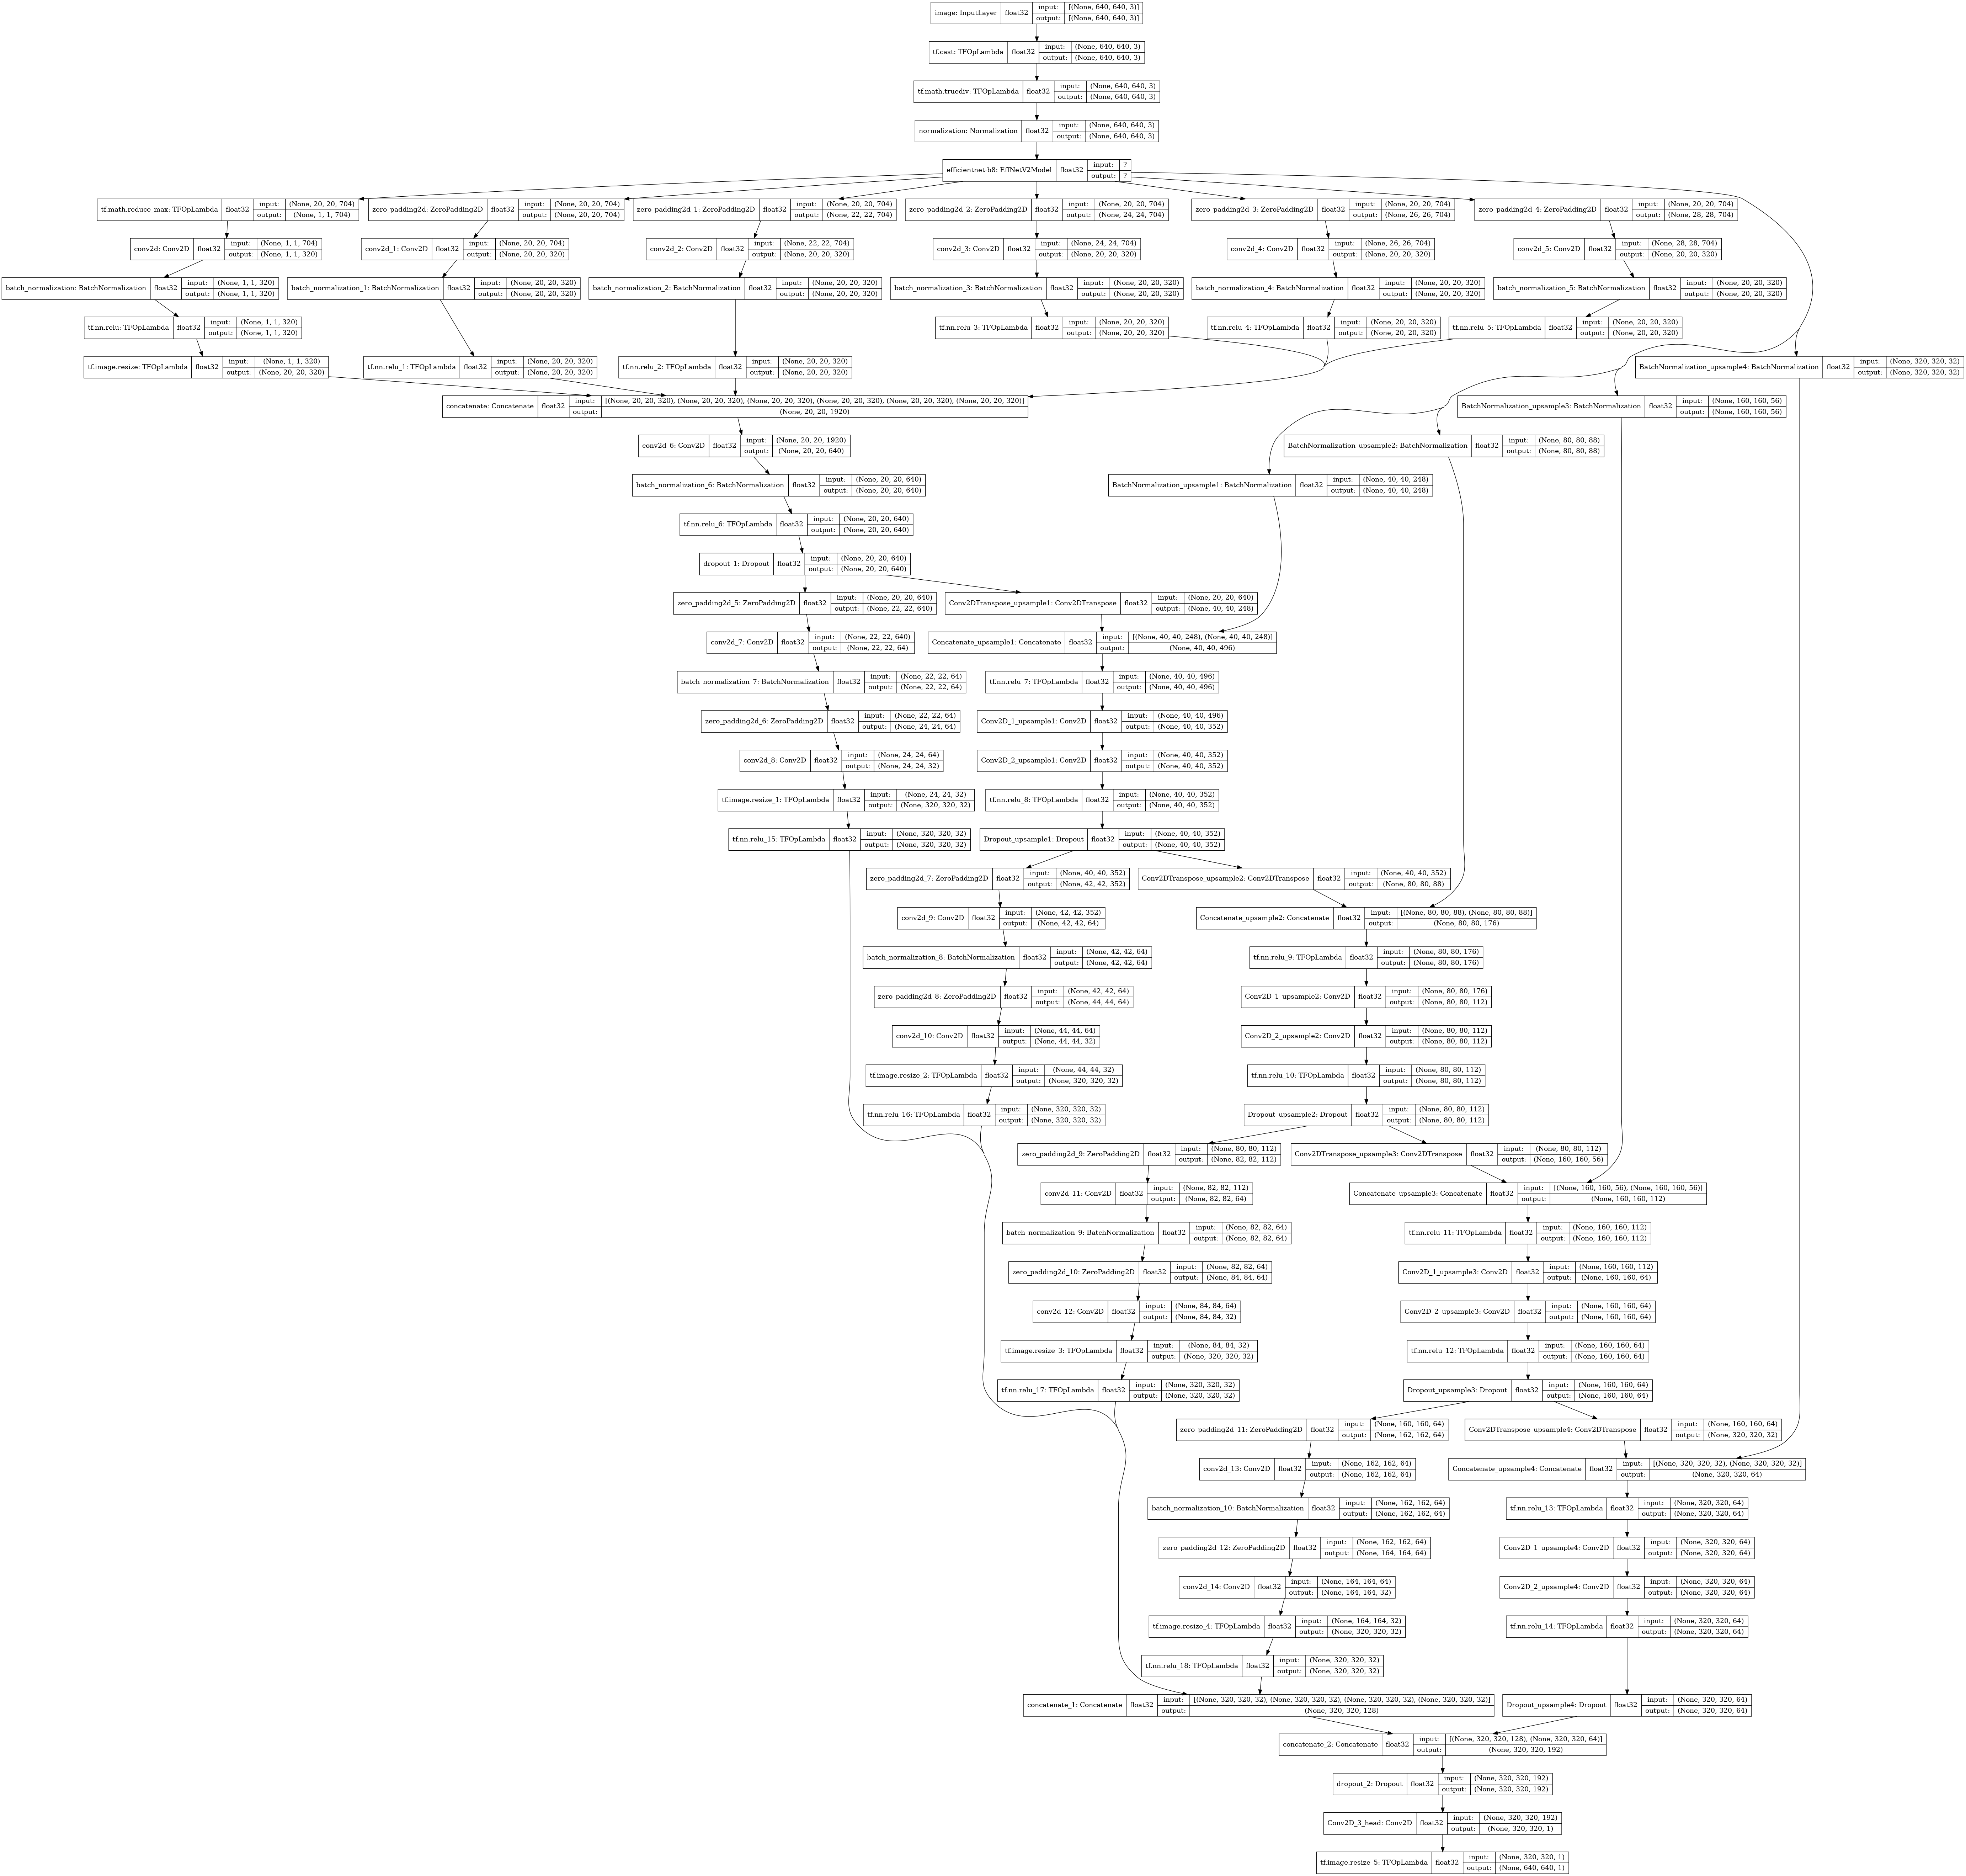

In [45]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True)

# Augmentations
Since the train set is different from the train set heavy augmentations are required to make the molde generalize well.

# Dataset

In [46]:
# Function to benchmark the dataset
def benchmark_dataset(dataset, num_epochs=3, n_steps_per_epoch=10, bs=BATCH_SIZE):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for idx, (images, labels) in enumerate(dataset.take(n_steps_per_epoch + 1)):
            if idx == 0:
                epoch_start = time.perf_counter()
            elif idx == 1 and epoch_num == 0:
                print(f'image shape: {images.shape}, image dtype: {images.dtype}')
            else:
                pass
        epoch_t = time.perf_counter() - epoch_start
        mean_step_t = round(epoch_t / n_steps_per_epoch * 1000, 1)
        n_imgs_per_s = int(1 / (mean_step_t / 1000) * bs)
        print(f'epoch {epoch_num} took: {round(epoch_t, 2)} sec, mean step duration: {mean_step_t}ms, images/s: {n_imgs_per_s}')

In [47]:
# Plots a batch of images
def show_batch(dataset, rows=4, cols=4):
    imgs, lbls = next(iter(dataset))
    imgs = imgs.numpy()
    # Plot
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(rows*4, cols*4))
    for r in range(rows):
        for c in range(cols // 2):
            img = imgs[r*cols+c]
            axes[r, c*2].imshow(img)
            axes[r, c*2].set_title(f'std: {img.std():.1f}')
            lbl = lbls[r*cols+c]
            axes[r, c*2+1].imshow(lbl)

In [48]:
# Decodes the TFRecords
def decode_image(record_bytes, val):
    features = tf.io.parse_single_example(record_bytes, {
        'image': tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
        'organ': tf.io.FixedLenFeature([], tf.string),
    })

    image = tf.io.parse_tensor(features['image'], out_type=tf.uint8)
    image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, N_CHANNELS])
    
    mask = tf.io.parse_tensor(features['mask'], out_type=tf.uint8)
    mask = tf.reshape(mask, [IMG_SIZE, IMG_SIZE, 1])
    
    # Ogran
    organ = features['organ']
    
    return image, mask, organ

In [30]:
def augment_image(image, mask, organ, val, return_organ):
    
    if not val:
        rotations = tf_rand_int(0, 4, dtype=tf.int32)

        image = tf.image.rot90(image, rotations)
        mask = tf.image.rot90(mask, rotations)
        
        if one_in(2):
            image = tf.image.transpose(image)
            mask = tf.image.transpose(mask)
        
        # Pixel Level Augmentations
        if one_in(2):
            image = tf.image.random_hue(image, 0.2)
        if one_in(2):
            image = tf.image.random_saturation(image, 0.80, 1.20)
        if one_in(2):
            image = tf.image.random_contrast(image, 0.80, 1.20)
        if one_in(2):
            image = tf.image.random_brightness(image, 0.10)
        if one_in(2):
            image = tf.image.random_jpeg_quality(image, 75, 100)
        
        # Random Crop
        offset_x = tf.random.uniform([], 0, tf.cast(IMG_SIZE * 0.50, tf.int32), dtype=tf.int32)
        img_size_crop = IMG_SIZE - offset_x
        if offset_x > 0:
            offset_y = tf.random.uniform([], 0, offset_x, dtype=tf.int32)
        else:
            offset_y = tf.constant(0, dtype=tf.int32)

        # Crop
        if one_in(2):
            image = tf.slice(image, [offset_x, offset_y, 0], [img_size_crop, img_size_crop, N_CHANNELS])
            mask = tf.slice(mask, [offset_x, offset_y, 0], [img_size_crop, img_size_crop, 1])
            
            image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.BICUBIC)
            image = tf.cast(image / tf.reduce_max(image) * 255, tf.uint8)
            
            mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        
        # Rotate
        if one_in(2):
            angle = tf.random.uniform([], -45 * math.pi / 180, 45 * math.pi / 180, dtype=tf.float32)
            image = tfa.image.rotate(image, angle, interpolation='bilinear', fill_mode='reflect')
            mask = tfa.image.rotate(mask, angle, interpolation='nearest', fill_mode='reflect')
        
        # Resize
        image = tf.cast(image / tf.reduce_max(image) * 255, tf.uint8)
        
        # Explicit Reshape for TPU
        image = tf.reshape(image, [IMG_SIZE, IMG_SIZE, N_CHANNELS])
        mask = tf.reshape(mask, [IMG_SIZE, IMG_SIZE, 1])

    if return_organ:
        return image, mask, organ
    else:
        return image, mask

In [49]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('hubmap-patched-tfrecords-300x300')
print(f'GCS_DS_PATH: {GCS_DS_PATH}')

TFRECORDS_FILE_PATHS = np.array(tf.io.gfile.glob(f'{GCS_DS_PATH}/*.tfrecords'))
TFRECORDS_FILE_PATHS = np.array(
    sorted(TFRECORDS_FILE_PATHS, key=lambda fp: int(fp.split('.')[-2].split('_')[-1]))
)
print(f'Found {len(TFRECORDS_FILE_PATHS)} TFRecords')

GCS_DS_PATH: gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b
Found 351 TFRecords


2022-09-19 21:31:44.658717: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [50]:
# Check whether file paths are correctly ordered
pd.options.display.max_colwidth = 999
display(pd.DataFrame(TFRECORDS_FILE_PATHS, columns=['File Path']).sample(10, random_state=SEED))

File Path
82    gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_82.tfrecords
233  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_233.tfrecords
183  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_183.tfrecords
226  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_226.tfrecords
205  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_205.tfrecords
38    gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_38.tfrecords
221  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_221.tfrecords
167  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_167.tfrecords
315  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_315.tfrecords
281  gs://kds-484fcc7de73d4c976b3703fffb37689fa3167a99f8c2381ef8ba878b/batch_281.tfrecords

In [31]:
N_SAMPLES_PER_TFRECORD = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/N_SAMPLES_PER_TFRECORD.npy')
print(f'N_SAMPLES_PER_TFRECORD shape: {N_SAMPLES_PER_TFRECORD.shape}, dtype: {N_SAMPLES_PER_TFRECORD.dtype}')

N_SAMPLES_PER_TFRECORD shape: (351,), dtype: int16


In [51]:
def get_dataset(tfrecord_idxs=None, bs=BATCH_SIZE, idxs=None, return_steps=False, val=False, return_organ=False, debug=False):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    if IS_TPU:
        npr = 1 if val else AUTO
    else:
        npr = 1 if val else cpu_count()
    
    if tfrecord_idxs is None:
        dataset = tf.data.TFRecordDataset(TFRECORDS_FILE_PATHS, num_parallel_reads=npr)
    else:
        dataset = tf.data.TFRecordDataset(TFRECORDS_FILE_PATHS[tfrecord_idxs], num_parallel_reads=npr)
    
    dataset = dataset.map(
        lambda record_bytes: decode_image(record_bytes, val), num_parallel_calls=AUTO if IS_TPU else 1
    )
    
    # Cache dataset to speedup dataloader
    if not debug:
        dataset = dataset.cache()
    
    if not val and not debug:
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.shuffle(128)
        dataset = dataset.repeat()
    
    # Augment
    dataset = dataset.map(
        lambda image, mask, organ: augment_image(image, mask, organ, val, return_organ), num_parallel_calls=npr
    )

    dataset = dataset.batch(bs, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    
    if return_steps:
        return dataset, math.ceil(N_SAMPLES_PER_TFRECORD[tfrecord_idxs].sum() / bs)
    else:
        return dataset

In [52]:
# Benchmark Dataset
benchmark_dataset(get_dataset(debug=True))

image shape: (32, 640, 640, 3), image dtype: <dtype: 'uint8'>
epoch 0 took: 17.52 sec, mean step duration: 1752.3ms, images/s: 18


2022-09-19 21:33:17.318156: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 156296, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663623197.314787231","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 156296, Output num: 1","grpc_status":3}


epoch 1 took: 8.05 sec, mean step duration: 805.1ms, images/s: 39
epoch 2 took: 8.18 sec, mean step duration: 818.0ms, images/s: 39


In [53]:
# Sanity check
images, labels = next(iter(get_dataset(debug=True)))
print(f'images shape: {images.shape}, labels shape: {labels.shape}')
print(f'images dtype: {images.dtype}, labels dtype: {labels.dtype}')

percentiles = [0.01, 0.05, 0.10, 0.25, 0.40 ,0.50, 0.60, 0.75, 0.90, 0.95, 0.99]
display(pd.Series(images.numpy().flatten()).describe(percentiles=percentiles).to_frame(name='images').T)
display(pd.Series(labels.numpy().flatten()).value_counts().to_frame(name='labels').T)

images shape: (32, 640, 640, 3), labels shape: (32, 640, 640, 1)
images dtype: <dtype: 'uint8'>, labels dtype: <dtype: 'uint8'>


count       mean        std  min   1%   5%  10%  25%   40%   50%  \
images  39321600.0  54.140337  53.146418  0.0  0.0  0.0  0.0  6.0  20.0  38.0   

         60%   75%    90%    95%    99%    max  
images  62.0  92.0  134.0  156.0  188.0  255.0

0        1
labels  11290540  1816660

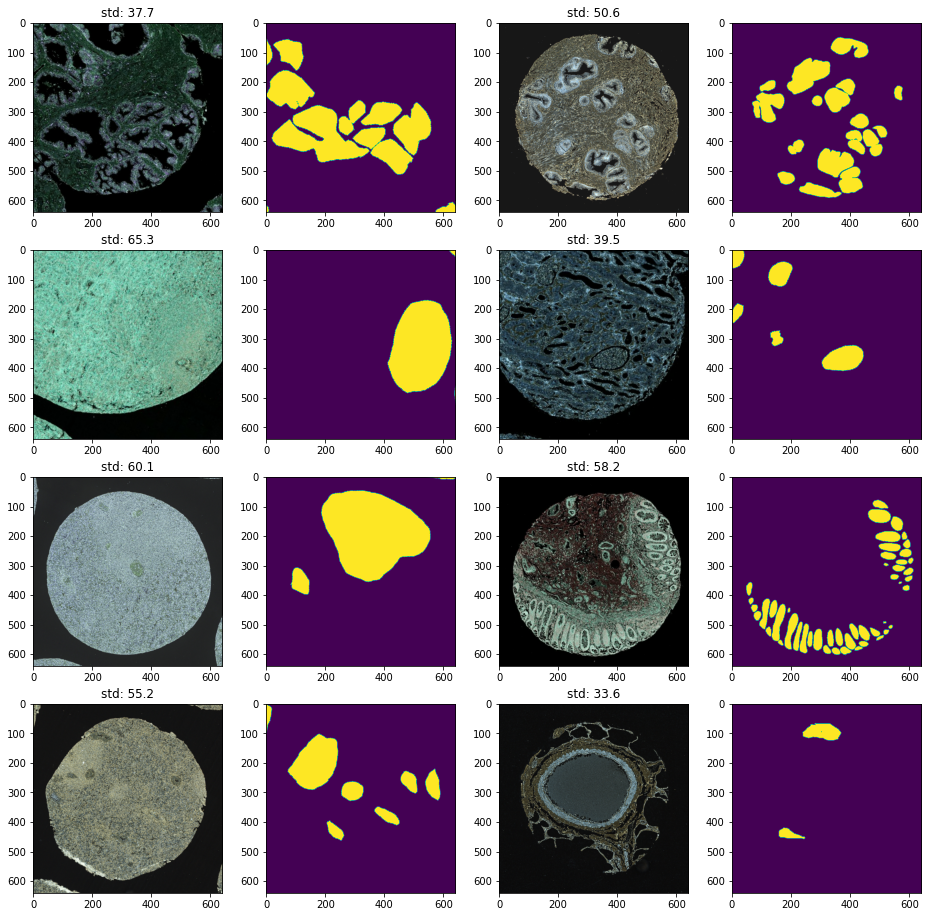

In [54]:
# Show what we will be training on
show_batch(get_dataset(bs=16, debug=True))

# Weights Initialization
The following function shows the intermediate values during a forward pass. It is important for values to not explode (become huge) or vanish (become tiny), as this will affect the gradient update by having too large or too small updates. Moreover, many values are concatenated in a UNet architecture, those values should have equal distributions, otherwise consecutive layers will only pay attention to a single part of the input. Lastly, the output sigmoid function should be initialized to be centered around 0.50 to start with large gradients. If all values are near 0 or near 1 at the start gradients will be tiny as the slope of the sigmoid function is near straight at 0 or 1.

It is a lot of work to get statistics on all intermediate values and plot the output, however it gives you a good understanding of how a neural network behaves, and, more importantly, why it could not behave the way you expect it to do.

images shape: (8, 640, 640, 3)


2022-09-19 21:36:02.394356: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:36:02.579638: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:36:02.773692: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:36:02.852710: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:36:02.930310: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


embedding shape: (None, 2816) up1 shape: (None, 20, 20, 2816), up2 shape: (None, 20, 20, 704)
up3 shape: (None, 40, 40, 248), up4 shape: (None, 80, 80, 88), up5 shape: (None, 160, 160, 56), up6 shape: (None, 320, 320, 32)
dec0 shape: (None, 20, 20, 640), dec1 shape: (None, 40, 40, 352), dec2 shape: (None, 80, 80, 112), dec3 shape: (None, 160, 160, 64), dec4 shape: (None, 320, 320, 32)
dec_fpn shape: (None, 320, 320, 160)


count  mean   std   min    1%    5%   10%   25%   40%   50%  \
image_norm  9830400.0  0.12  0.52 -0.43 -0.43 -0.43 -0.41 -0.38 -0.21 -0.05   

             60%   75%   90%   95%   99%   max  
image_norm  0.16  0.47  0.93  1.17  1.44  2.03

count  mean   std   min    1%   5%   10%   25%   40%   50%   60%  \
embedding  22528.0  0.03  0.18 -0.25 -0.22 -0.2 -0.17 -0.11 -0.06 -0.02  0.03   

            75%   90%   95%   99%   max  
embedding  0.12  0.28  0.38  0.61  1.21

count  mean   std    min     1%    5%   10%   25%   40%   50%   60%  \
up6  26214400.0  0.33  3.88 -65.76 -10.33 -5.39 -3.32 -1.36 -0.39  0.09  0.81   

      75%   90%   95%    99%    max  
up6  1.63  4.38  6.74  12.99  94.21

count  mean   std    min     1%    5%   10%   25%   40%   50%  60%  \
up5  11468800.0  -0.1  6.05 -88.86 -16.32 -9.68 -7.03 -3.55 -1.28 -0.05  1.2   

      75%   90%   95%    99%     max  
up5  3.41  6.54  9.01  15.85  131.24

count  mean   std    min     1%    5%   10%   25%   40%   50%   60%  \
up4  4505600.0 -0.13  4.15 -37.99 -10.36 -6.85 -5.22 -2.78 -1.17 -0.17  0.85   

      75%   90%   95%   99%    max  
up4  2.52  5.09  6.75  9.89  44.08

count  mean   std    min     1%    5%   10%   25%   40%   50%   60%  \
up3  3174400.0 -0.37  3.97 -47.39 -10.74 -6.96 -5.22 -2.69 -1.19 -0.32  0.54   

      75%   90%   95%   99%    max  
up3  2.02  4.41  6.05  9.59  28.87

count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
up2  2252800.0 -0.01  2.03 -22.3 -5.55 -3.24 -2.31 -1.07 -0.38 -0.01  0.37   

      75%   90%  95%   99%    max  
up2  1.04  2.27  3.2  5.51  24.98

count  mean   std   min    1%    5%   10%   25%   40%  50%   60%  \
up1  9011200.0  0.03  0.56 -0.28 -0.28 -0.28 -0.28 -0.26 -0.23 -0.2 -0.14   

      75%   90%   95%   99%    max  
up1  0.04  0.58  1.11  2.55  11.89

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
dec0  2048000.0  0.99  1.57  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.55  1.57   

       90%   95%  99%    max  
dec0  3.17  4.26  6.7  18.86

count  mean  std  min   1%   5%  10%  25%  40%  50%   60%   75%   90%  \
x0  1024000.0  0.86  1.3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.52  1.42  2.78   

     95%  99%   max  
x0  3.65  5.3  7.48

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
xs0  1024000.0  1.02  1.73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.52  1.47   

     90%   95%   99%    max  
xs0  3.2  4.52  7.78  30.82

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
xs1  1024000.0  1.08  1.75  0.0  0.0  0.0  0.0  0.0  0.0  0.06  0.62  1.61   

      90%   95%   99%    max  
xs1  3.37  4.65  7.64  23.91

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
xs2  1024000.0  1.03  1.62  0.0  0.0  0.0  0.0  0.0  0.0  0.03  0.59  1.58   

      90%   95%  99%    max  
xs2  3.25  4.42  7.0  20.37

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
xs3  1024000.0  1.02  1.57  0.0  0.0  0.0  0.0  0.0  0.0  0.06  0.63  1.62   

      90%   95%   99%    max  
xs3  3.23  4.32  6.65  18.69

count  mean  std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
xs4  1024000.0  0.97  1.5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.55  1.52   

      90%   95%   99%   max  
xs4  3.09  4.15  6.34  16.5

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
dec1  4505600.0  0.59  0.92  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.31  0.92   

       90%   95%   99%    max  
dec1  1.89  2.55  3.93  11.66

count  mean   std    min   1%    5%   10%  25%   40%   50%   60%  \
dec1_up  3174400.0  0.02  2.04 -20.37 -5.2 -3.29 -2.44 -1.2 -0.43  0.01  0.46   

          75%   90%   95%   99%    max  
dec1_up  1.24  2.48  3.33  5.16  17.97

count  mean   std    min    1%    5%  10%   25%  40%   50%  \
dec1_concat  3174400.0 -0.09  0.99 -11.84 -2.68 -1.74 -1.3 -0.67 -0.3 -0.08   

              60%  75%  90%   95%  99%   max  
dec1_concat  0.14  0.5  1.1  1.51  2.4  7.21

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
dec2  5734400.0  0.47  0.73  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.26  0.76   

       90%  95%   99%   max  
dec2  1.52  2.0  2.97  8.12

count  mean   std    min    1%    5%   10%   25%   40%   50%  \
dec2_up  4505600.0  0.01  1.56 -10.91 -3.95 -2.57 -1.91 -0.92 -0.32  0.02   

          60%   75%   90%   95%   99%    max  
dec2_up  0.35  0.95  1.91  2.56  3.91  13.51

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec2_concat  4505600.0 -0.03  1.04 -9.49 -2.59 -1.71 -1.31 -0.69 -0.29 -0.04   

              60%   75%   90%   95%   99%    max  
dec2_concat  0.21  0.63  1.27  1.69  2.47  11.02

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%   75%  \
dec3  13107200.0  0.43  0.65  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.26  0.71   

       90%   95%   99%    max  
dec3  1.37  1.83  2.84  11.82

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec3_up  11468800.0  0.05  0.83 -7.32 -1.99 -1.32 -0.99 -0.47 -0.14  0.05   

          60%   75%  90%   95%   99%   max  
dec3_up  0.24  0.58  1.1  1.43  2.13  6.06

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec3_concat  11468800.0 -0.03  1.51 -22.2 -4.08 -2.42 -1.76 -0.89 -0.32 -0.01   

             60%   75%   90%   95%   99%    max  
dec3_concat  0.3  0.85  1.63  2.25  3.96  32.79

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%   75%  \
dec4  26214400.0  0.47  0.65  0.0  0.0  0.0  0.0  0.0  0.0  0.12  0.34  0.74   

       90%   95%   99%    max  
dec4  1.43  1.93  3.05  10.43

count  mean   std   min    1%    5%   10%   25%   40%   50%  \
dec4_up  26214400.0  0.02  0.84 -8.47 -2.04 -1.35 -1.03 -0.52 -0.19  0.01   

         60%   75%   90%   95%   99%   max  
dec4_up  0.2  0.53  1.07  1.43  2.23  9.59

count  mean   std    min    1%    5%   10%   25%  40%   50%  \
dec4_concat  26214400.0  0.08  0.97 -16.43 -2.58 -1.35 -0.83 -0.34 -0.1  0.02   

             60%   75%   90%   95%   99%    max  
dec4_concat  0.2  0.41  1.09  1.68  3.25  23.54

count  mean   std  min   1%   5%  10%  25%  40%   50%   60%  \
dec_fpn  131072000.0  0.37  0.76  0.0  0.0  0.0  0.0  0.0  0.0  0.03  0.25   

         75%   90%   95%   99%    max  
dec_fpn  0.7  1.59  2.22  3.57  17.53

count  mean   std  min   1%   5%  10%  25%  40%  50%   60%  \
dec_fpn_xs  104857600.0   0.4  0.79  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.23   

             75%   90%   95%  99%    max  
dec_fpn_xs  0.68  1.64  2.29  3.7  17.53

count  mean   std   min    1%    5%   10%   25%   40%   50%   60%  \
output  3276800.0  0.71  0.45 -0.61 -0.02  0.09  0.17  0.36  0.54  0.66  0.78   

         75%   90%   95%   99%   max  
output  0.99  1.31  1.51  1.96  3.27

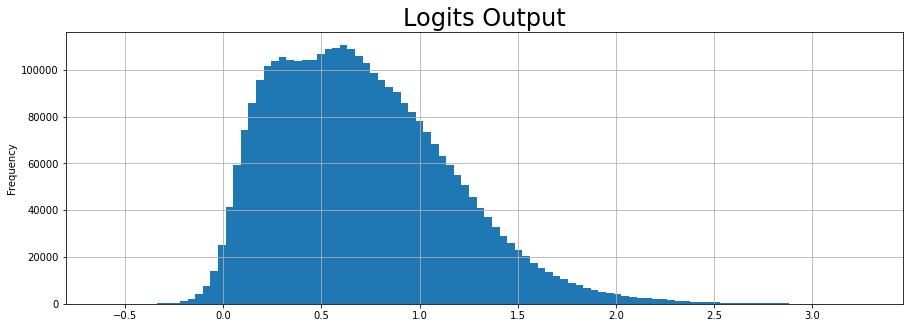

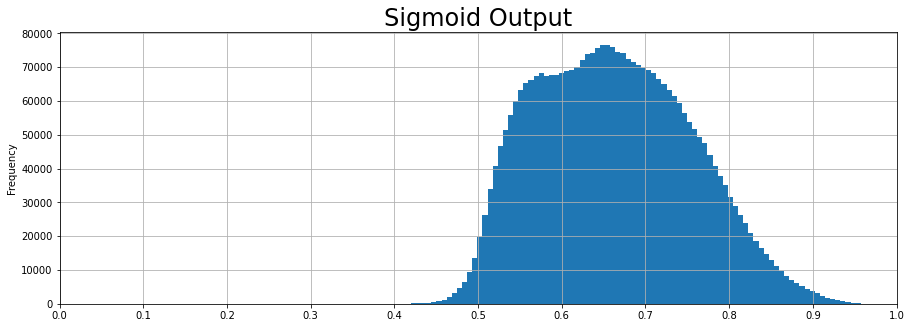

In [55]:
def weight_init_analysis():
    # Get large batch
    images, _ = next(iter(get_dataset(bs=8, debug=True)))
    print(f'images shape: {images.shape}')
    
    tf.keras.backend.clear_session()
    gc.collect()
    model = get_model(file_path=None, debug=True)
    
    (
        image_norm,
        embedding, up6, up5, up4, up3, up2, up1,
        dec0, x0, xs0, xs1, xs2, xs3, xs4, 
        dec1, dec1_up, dec1_concat,
        dec2, dec2_up, dec2_concat,
        dec3, dec3_up, dec3_concat,
        dec4, dec4_up, dec4_concat,
        dec_fpn, dec_fpn_xs, output
    ) = model(images, training=False) 

    percentiles = [0.01, 0.05, 0.10, 0.25, 0.40, 0.50, 0.60, 0.75, 0.90, 0.95, 0.99]

    for v, v_name in zip(
        [image_norm, embedding, up6, up5, up4, up3, up2, up1, dec0, x0, xs0, xs1, xs2, xs3, xs4, dec1, dec1_up, dec1_concat, dec2, dec2_up, dec2_concat, dec3, dec3_up, dec3_concat, dec4, dec4_up, dec4_concat, dec_fpn, dec_fpn_xs, output],
        ['image_norm', 'embedding', 'up6', 'up5', 'up4', 'up3', 'up2', 'up1', 'dec0', 'x0', 'xs0', 'xs1', 'xs2', 'xs3', 'xs4', 'dec1', 'dec1_up', 'dec1_concat', 'dec2', 'dec2_up', 'dec2_concat', 'dec3', 'dec3_up', 'dec3_concat', 'dec4', 'dec4_up', 'dec4_concat', 'dec_fpn', 'dec_fpn_xs', 'output'],
    ):
        display(pd.Series(v.numpy().flatten()).describe(percentiles=percentiles).astype(float).round(2).to_frame(name=v_name).T)
        print('=' * 50)

    # Histogram
    plt.figure(figsize=(15,5))
    plt.title('Logits Output', size=24)
    pd.Series(output.numpy().flatten()).plot(kind='hist', bins=100)
    plt.grid()
    plt.show()

    # Histogram
    plt.figure(figsize=(15,5))
    plt.title('Sigmoid Output', size=24)
    pd.Series(tf.math.sigmoid(output).numpy().flatten()).plot(kind='hist', bins=100)
    plt.xticks(np.arange(0.0, 1.1, 0.1))
    plt.grid()
    plt.show()
    
weight_init_analysis()

In [58]:
gc.collect()

23

# Learning Rate Scheduler
An learning rate scheduler is used with a cosine decay and exponential warmup

In [35]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=EPOCHS_WHOLE):
    
    if current_step < num_warmup_steps:
        return lr_max * 0.50 ** (num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

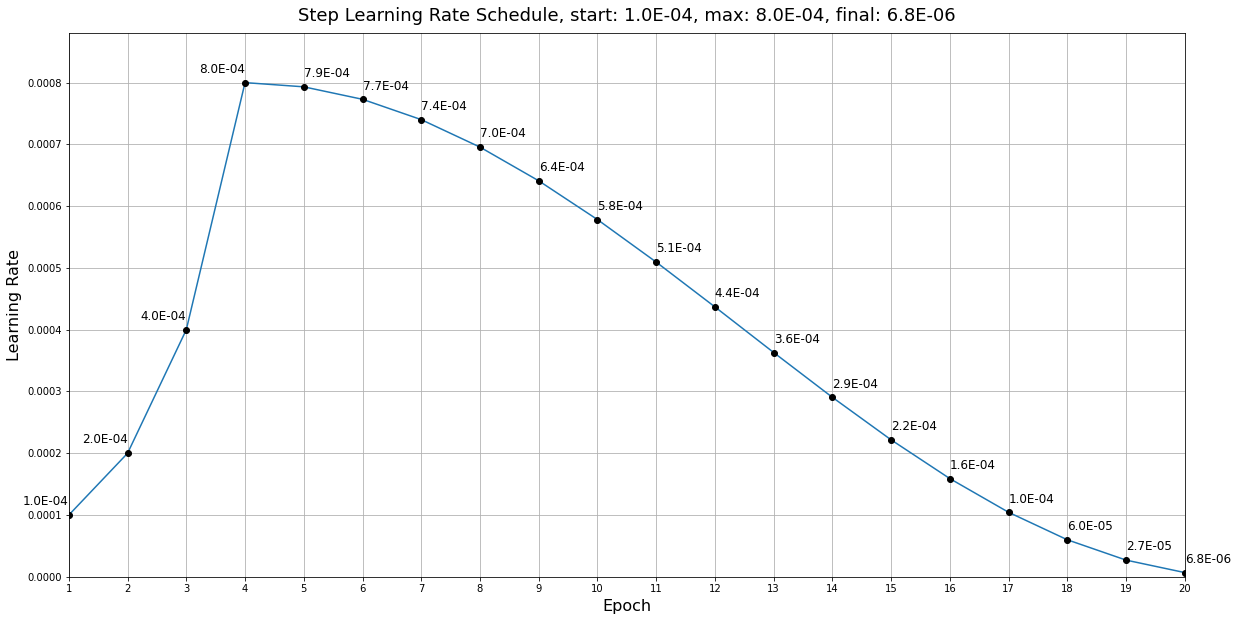

In [36]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=3, lr_max=LR_MAX_WHOLE, num_cycles=0.50) for step in range(EPOCHS_WHOLE)]
plot_lr_schedule(LR_SCHEDULE, epochs=EPOCHS_WHOLE)


# Training Whole Model

In [59]:
ORGAN_PER_TFRECORD = np.load('/kaggle/input/hubmap-patched-tfrecords-300x300/ORGAN_PER_TFRECORD.npy')

In [60]:
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [62]:
from sklearn.model_selection import StratifiedKFold
# Create KFOLDS
FOLDS = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
HISTORIES = dict()
IDXS = { 'train_idxs': [], 'val_idxs': [] }
for fold, (train_idxs, val_idxs) in enumerate(FOLDS.split(X=TFRECORDS_FILE_PATHS, y=ORGAN_PER_TFRECORD)):
    # Only train selected folds
    if fold not in TRAIN_FOLDS:
        continue
    
    IDXS['train_idxs'].append(train_idxs)
    IDXS['val_idxs'].append(val_idxs)
    train_dataset, train_steps_per_epoch = get_dataset(tfrecord_idxs=train_idxs, bs=BATCH_SIZE, return_steps=True)
    val_dataset, val_steps_per_epoch = get_dataset(tfrecord_idxs=val_idxs, bs=N_PATCHES_PER_IMAGE * REPLICAS, return_steps=True, val=True)
    print('=' * 80)
    print(f'FOLD {fold}, train_steps_per_epoch: {train_steps_per_epoch}, val_steps_per_epoch: {val_steps_per_epoch}')
    print('=' * 80)
    
    tf.keras.backend.clear_session()
    gc.collect()
    
    model = get_model(file_path=None, cnn_trainable=True, lr=LR_MAX_WHOLE, eps=1e-5)
    if fold == TRAIN_FOLDS[0]:
        print(model.summary())
    
    HISTORIES[fold] = model.fit(
        train_dataset,
        steps_per_epoch = train_steps_per_epoch * COMBINE_EPOCHS,
        validation_data = val_dataset,
        epochs = EPOCHS_WHOLE,
        verbose = 2,
        callbacks = [
            lr_callback,
        ],
    )
    
    model.save_weights(f'model_{fold}.h5')
    
    print('\n' * 3)
    
    break

FOLD 0, train_steps_per_epoch: 9, val_steps_per_epoch: 11


2022-09-19 21:40:04.267534: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:40:04.400482: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:40:04.481903: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:40:04.564513: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-09-19 21:40:04.646922: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 640, 640, 3) 0                                            
__________________________________________________________________________________________________
tf.cast (TFOpLambda)            (None, 640, 640, 3)  0           image[0][0]                      
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 640, 640, 3)  0           tf.cast[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 640, 640, 3)  7           tf.math.truediv[0][0]            
______________________________________________________________________________________________

2022-09-19 21:47:12.125871: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 319318, Output num: 5
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1663624032.125040424","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 319318, Output num: 5","grpc_status":3}


Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002.
90/90 - 68s - loss: 0.1712 - iou: 0.4870 - precision: 0.7387 - recall: 0.5887 - auc: 0.9496 - binary_accuracy: 0.9273 - val_loss: 0.1356 - val_iou: 0.5259 - val_precision: 0.6902 - val_recall: 0.7641 - val_auc: 0.9721 - val_binary_accuracy: 0.9444
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0004.
90/90 - 68s - loss: 0.1167 - iou: 0.6444 - precision: 0.8289 - recall: 0.7553 - auc: 0.9770 - binary_accuracy: 0.9527 - val_loss: 0.1018 - val_iou: 0.5995 - val_precision: 0.8438 - val_recall: 0.7269 - val_auc: 0.9775 - val_binary_accuracy: 0.9608
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0008.
90/90 - 68s - loss: 0.1003 - iou: 0.6896 - precision: 0.8443 - recall: 0.8064 - auc: 0.9823 - binary_accuracy: 0.9604 - val_loss: 0.1632 - val_iou: 0.6048 - val_precision: 0.7517 - val_recall: 0.8329 - val_auc: 0.9676 - val_binary_accuracy: 0.9575
Epoch 5/20

E

# Training Visualisation¶
Training and validation predictions are plotted as a sanity check.

In [63]:
def plot_results(dataset, nrows, ncols=4):
    images, labels = next(iter(dataset))
    
    # Predict Masks
    labels_pred = model(images, training=False)
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*8, nrows*6))
    
    for r, (img, lbl, lbl_pred) in enumerate(zip(images, labels, labels_pred)):
        if r > nrows - 1: # zero indexed
            break
        # Plot Image
        axes[r, 0].imshow(img)
        axes[r, 0].set_title('Image', size=18)
        axes[r, 0].axis(False)
        
        # Mask
        axes[r, 1].imshow(lbl)
        axes[r, 1].set_title('Mask', size=18)
        axes[r, 1].axis(False)
        
        # Predicted Mask with Threshold
        axes[r, 2].imshow(lbl_pred)
        axes[r, 2].set_title('Mask Predicted', size=18)
        axes[r, 2].axis(False)
        
        # Predicted Mask with Threshold
        lbl_pred_th50 =tf.cast(lbl_pred > 0.50, tf.uint8)
        axes[r, 3].imshow(lbl_pred_th50)
        axes[r, 3].set_title('Mask Predicted Threshold 0.50', size=18)
        axes[r, 3].axis(False)

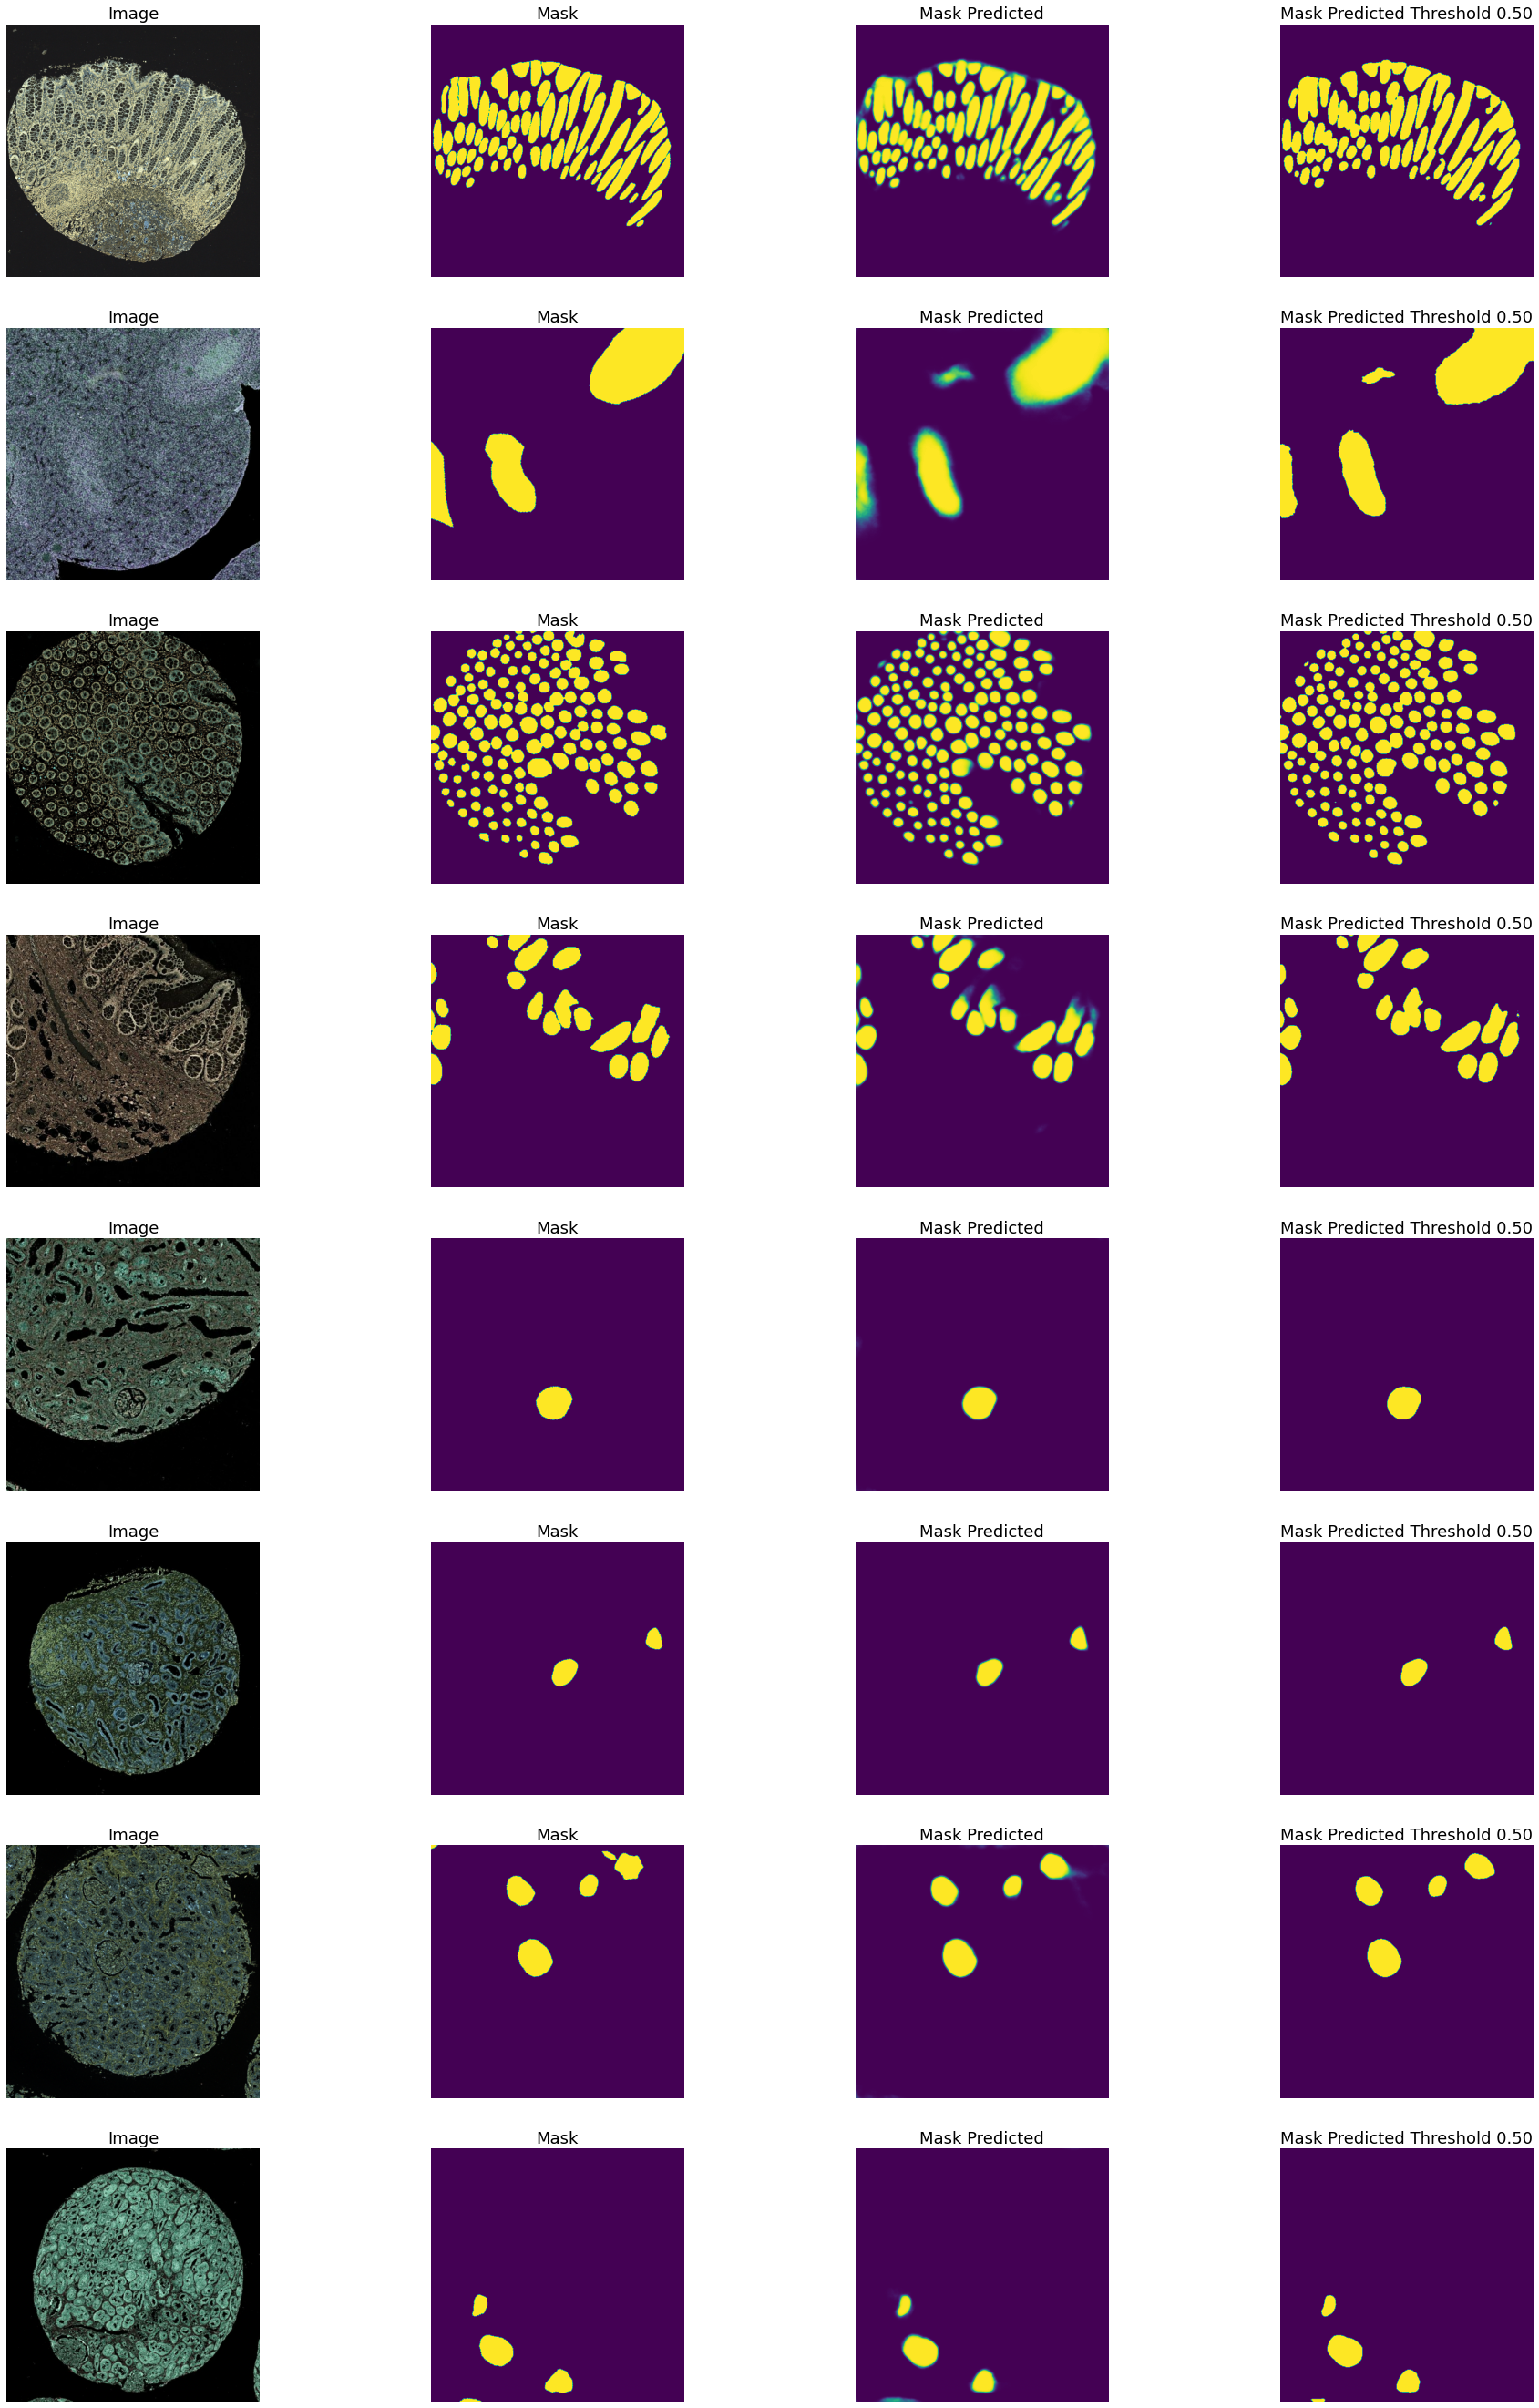

In [64]:
# Training Visualisation
plot_results(get_dataset(bs=8, idxs=train_idxs), 8)

# Training History
Plot training history metrics to get an understanding on how the model is learning.

In [65]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    for fold, history in HISTORIES.items():
        values = history.history[metric]
        N_EPOCHS = len(values)
        val = 'val' in ''.join(history.history.keys())
        # Epoch Ticks
        if N_EPOCHS <= 20:
            x = np.arange(1, N_EPOCHS + 1)
        else:
            x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]
        x_ticks = np.arange(1, N_EPOCHS+1)

        # Validation
        if val:
            val_values = history.history[f'val_{metric}']
            val_argmin = f_best(val_values)
            plt.plot(x_ticks, val_values, label=f'val_fold_{fold}')

        # summarize history for accuracy
        plt.plot(x_ticks, values, label=f'train_fold_{fold}')
        argmin = f_best(values)
        plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best_fold_{fold}')
        if val:
            plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best_fold_{fold}')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()

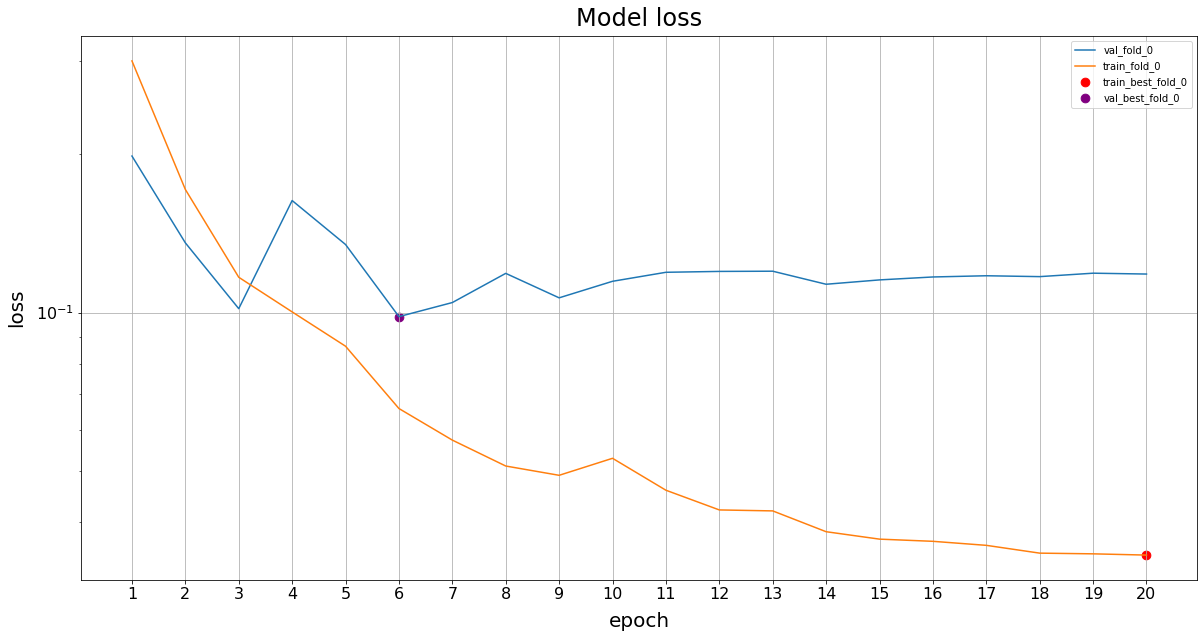

In [66]:
plot_history_metric('loss', f_best=np.argmin, yscale='log')

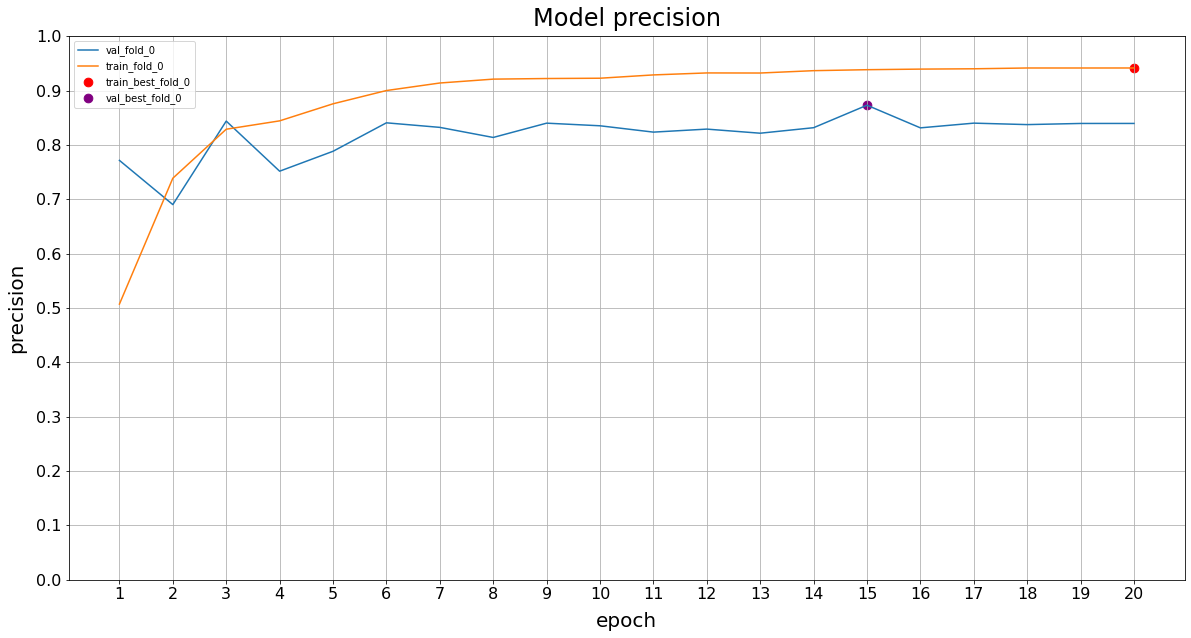

In [67]:
plot_history_metric('precision', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

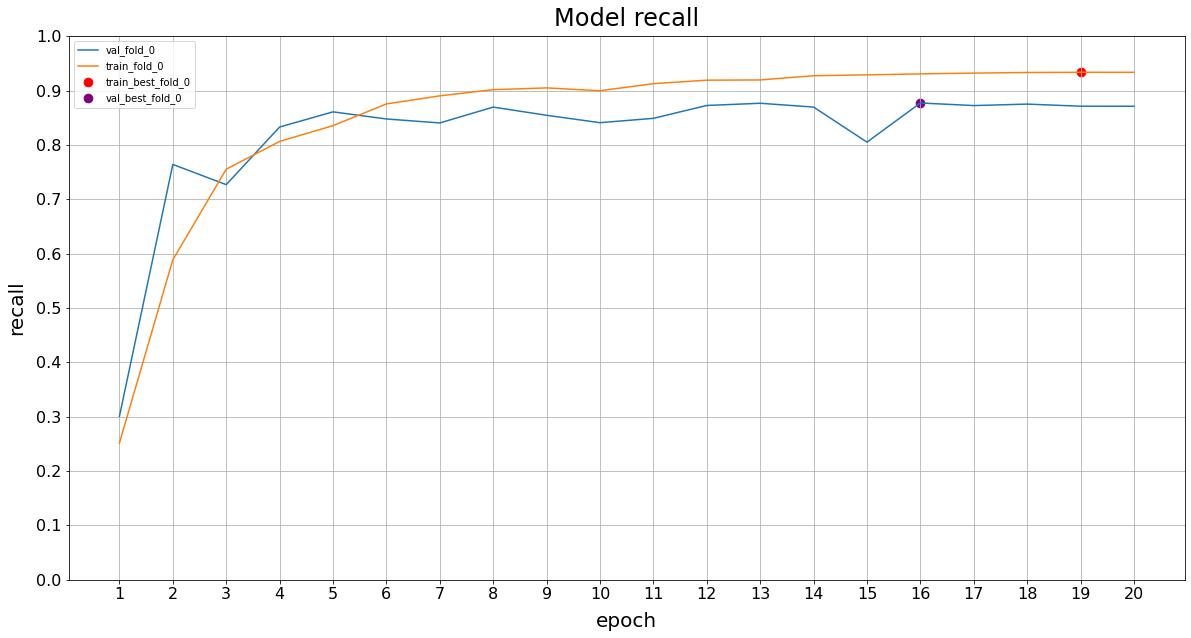

In [68]:
plot_history_metric('recall', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

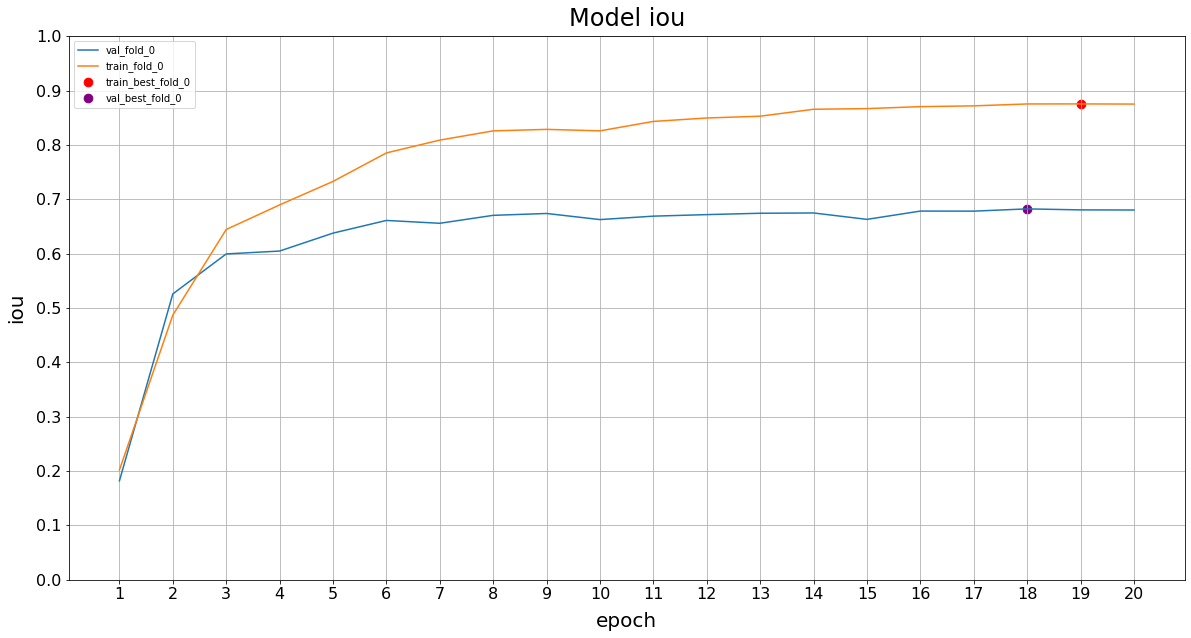

In [69]:
plot_history_metric('iou', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

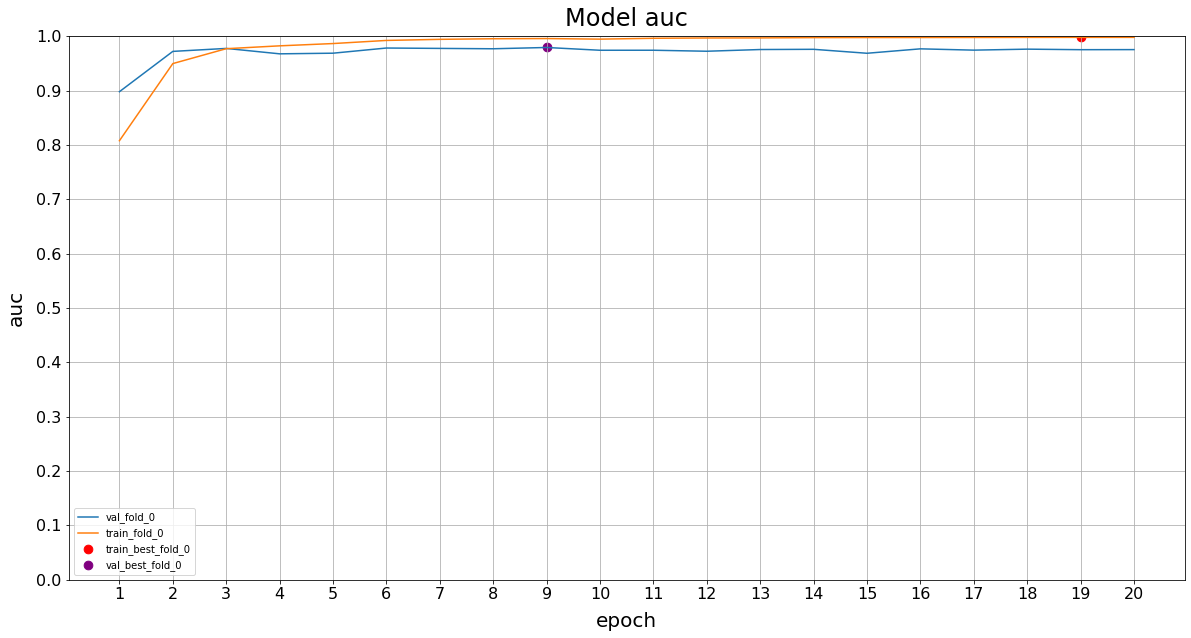

In [70]:
plot_history_metric('auc', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

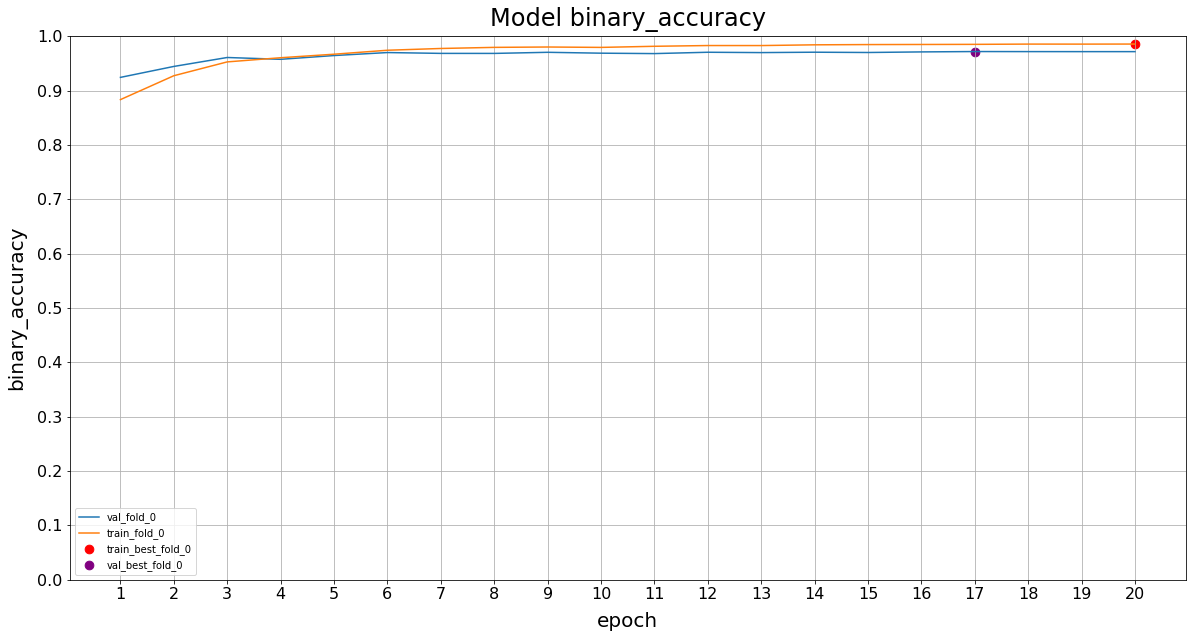

In [71]:
plot_history_metric('binary_accuracy', ylim=(0,1), yticks=np.arange(0, 1.1, 0.1))

# Validation Predictions

In [72]:
# Validation Dataset
dataset = get_dataset(
        tfrecord_idxs=val_idxs,
        bs=len(val_idxs),
        val=True,
        return_organ=True,
        debug=True,
    )

# Validation images, masks and organs
val_images, val_masks, val_organs = next(iter(dataset))
# Cast from Tensorflow to Numpy
val_images = val_images.numpy()
val_masks = val_masks.numpy()
val_organs = val_organs.numpy()
print(f'val_images shape: {val_images.shape}, val_masks shape: {val_masks.shape}, val_organs shape: {val_organs.shape}')

# Validation Predictions
VAL_Y_PREDS = model.predict(val_images, verbose=1, batch_size=len(val_idxs))
print(f'VAL_Y_PREDS shape: {VAL_Y_PREDS.shape}, VAL_Y_PREDS dtype: {VAL_Y_PREDS.dtype}')

val_images shape: (88, 640, 640, 3), val_masks shape: (88, 640, 640, 1), val_organs shape: (88,)
1/1 [==============================] - 31s 31s/step
VAL_Y_PREDS shape: (88, 640, 640, 1), VAL_Y_PREDS dtype: float32


# Mean Intersection Over Union By Threshold
Important analysis on the actual leaderboard metric, intersection over union, in general and per organ at different thresholds. The mean IoU per organ will vary widely, with the lung being by far the hardest to predict with a ~0.10 IoU.

In [74]:
def iou(y_true, y_pred):
    intersection = np.count_nonzero(y_true * y_pred)
    union = np.count_nonzero(y_true + y_pred)
    return intersection / union

In [75]:
# Predictions and true labels of validation dataset
def get_y_true_y_pred():
    thresholds = np.arange(0, 1.01, 0.01)
    IoUs = {}
    for t in thresholds:
        IoUs[t] = []
        
    IoUsOrgans = {}
    for o in ORGANS:
        IoUsOrgans[o] = {}
        for t in thresholds:
            IoUsOrgans[o][t] = []
    
    for idx, (image, y_true, organ, y_pred) in enumerate(zip(tqdm(val_images), val_masks, val_organs, VAL_Y_PREDS)):
        if idx == 0:
            print(f'image shape: {image.shape}, y_true shape: {y_true.shape}')
            print(f'organs: {organ.decode()}, y_pred shape: {y_pred.shape}')
        
        # Compute IoU for each threshold
        o = organ.decode()
        for t in thresholds:
            IoU = iou(y_true, (y_pred > t).astype(np.int8))
            IoUs[t].append(IoU)
            IoUsOrgans[o][t].append(IoU)
    
    return IoUs, IoUsOrgans

IoUs, IoUsOrgans = get_y_true_y_pred()

  0%|          | 0/88 [00:00<?, ?it/s]

image shape: (640, 640, 3), y_true shape: (640, 640, 1)
organs: prostate, y_pred shape: (640, 640, 1)


# Mean IoU at Threshold

In [77]:
def plot_iou_by_threshold(ious, name):
    thresholds = list(ious.keys())
    MeanIoUs = [np.mean(v)for v in ious.values()]

    plt.figure(figsize=(12,8))
    plt.title(f'Mean IoU by Threshold {name}', size=24)
    plt.plot(thresholds, MeanIoUs)
    plt.grid()
    plt.xlabel('Threshold', size=16)
    plt.ylabel('Mean IoU', size=16)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.ylim(0,1)

    # Best Threshold
    arg_best = np.argmax(MeanIoUs)
    threshold_best = thresholds[arg_best]
    mean_iou_best = MeanIoUs[arg_best]
    plt.scatter(threshold_best, mean_iou_best, color='red', s=100, marker='o', label=f'Best Mean IoU ({mean_iou_best:.3f}) at Threshold {threshold_best:.3f}')
    plt.legend(prop={'size': 16})

    plt.show()
    
    return threshold_best

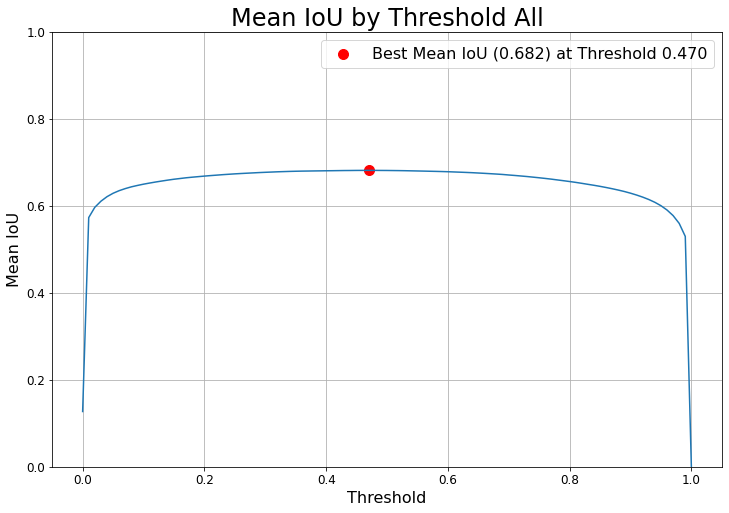

In [78]:
# Global Mean Intersection over Union at Threshold
threshold_best = plot_iou_by_threshold(IoUs, 'All')

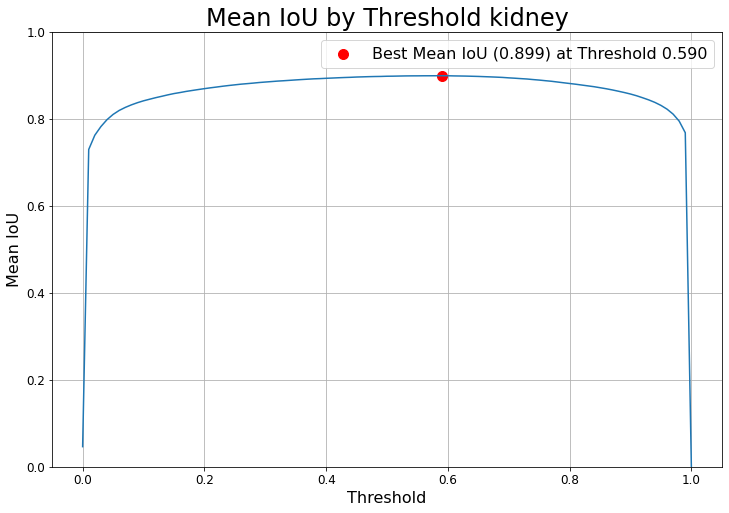

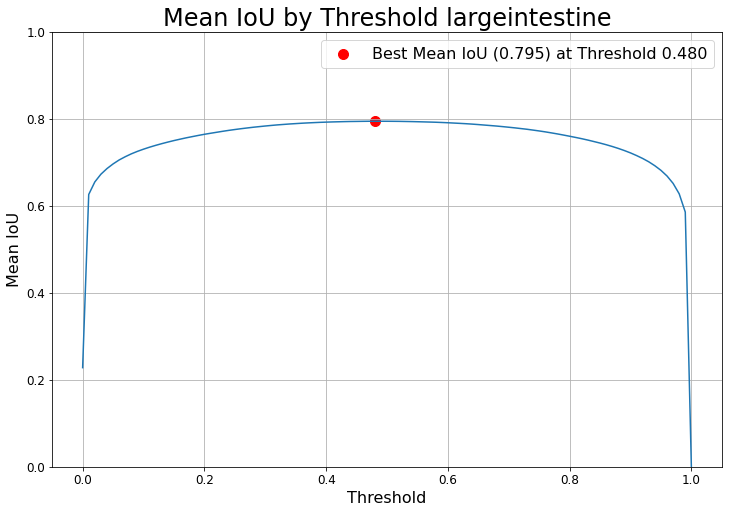

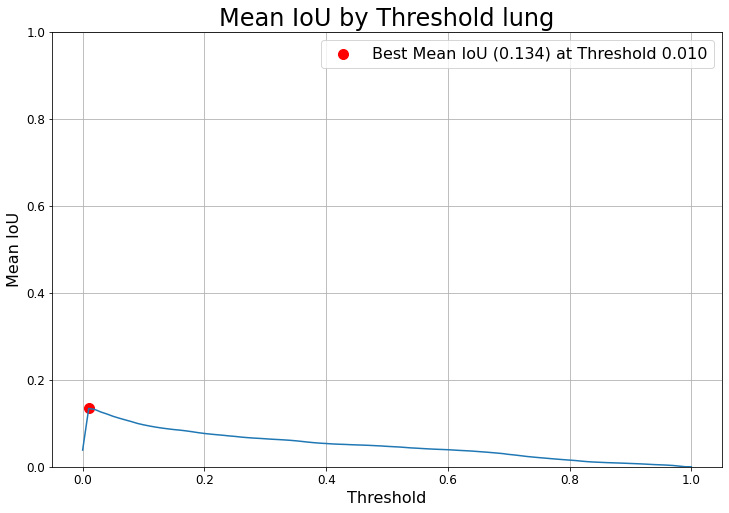

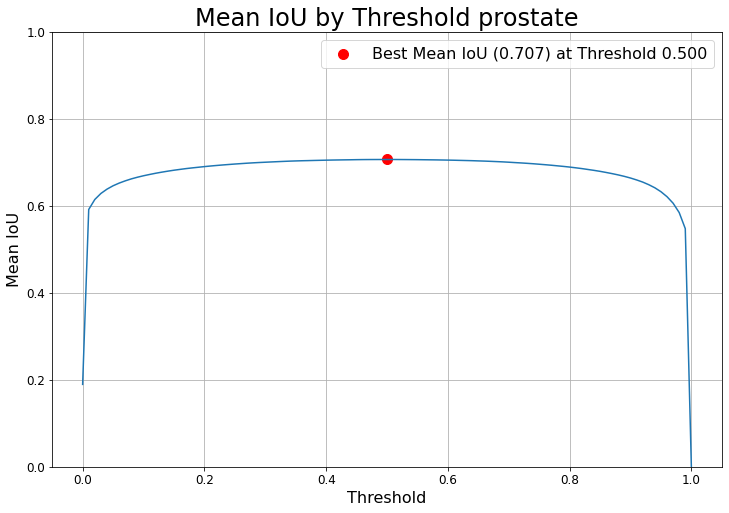

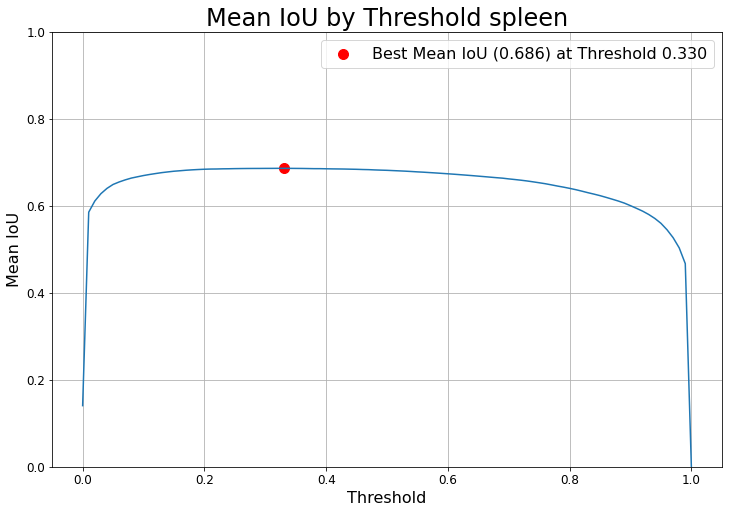

In [79]:
# Per Organ Mean Intersection over Union at Threshold
for organ, ious in IoUsOrgans.items():
    plot_iou_by_threshold(ious, organ)

# IoU Distribution Best Threshold

In [80]:
display(pd.Series(IoUs[threshold_best]).describe().apply(lambda v: f'{v:.2f}').to_frame(name='Value'))

Value
count  88.00
mean    0.68
std     0.32
min     0.00
25%     0.58
50%     0.83
75%     0.90
max     0.97

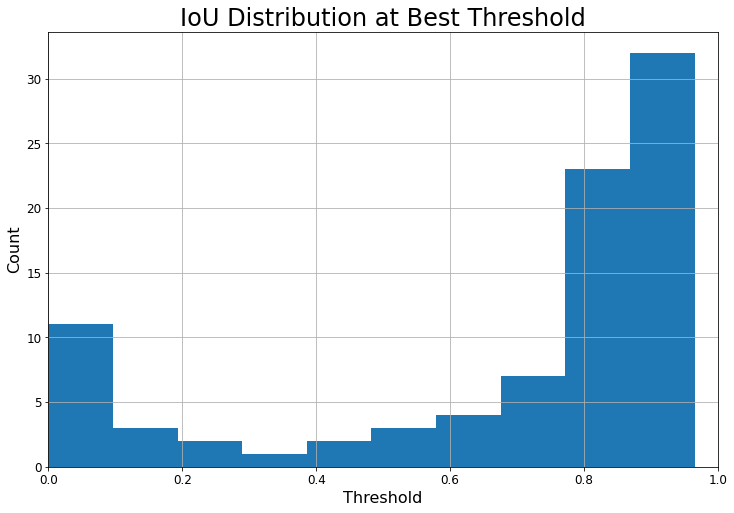

In [81]:
plt.figure(figsize=(12,8))
pd.Series(IoUs[threshold_best]).plot(kind='hist')
plt.title('IoU Distribution at Best Threshold', size=24)
plt.grid()
plt.xlabel('Threshold', size=16)
plt.ylabel('Count', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlim(0,1)
plt.show()

# Validation Prediction Visualization
Visualize all validation predictions with the following color codes:

RED False Positive: model predicted pixel to belong to mask but the pixel is actually a background pixel

BLUE False Negative: model predicted pixel to be background but it actually is a pixel belonging to the mask

GREEN True Positive: model predicted the pixel to belong to the mask, and it actually is a mask belonging to the mask!

In [83]:
gc.collect()

23

In [84]:
def merge_patches(patches):
    if len(patches.shape) == 3:
        return patches
    
    image = np.zeros(shape=[IMG_SIZE_FULL, IMG_SIZE_FULL, patches.shape[-1]], dtype=patches.dtype)
    s = int(N_PATCHES_PER_IMAGE ** 0.50)
    for r in range(s):
        for c in range(s):
            start_x = r * IMG_SIZE
            end_x = (r + 1) * IMG_SIZE
            start_y = c * IMG_SIZE
            end_y = (c + 1) * IMG_SIZE
            image[start_x:end_x, start_y:end_y] = patches[r * s + c]
            
    return image

In [ ]:
def merge_patches(patches):
    if len(patches.shape) == 3:
        return patches
    
    image = np.zeros(shape=[IMG_SIZE_FULL, IMG_SIZE_FULL, patches.shape[-1]], dtype=patches.dtype)
    s = int(N_PATCHES_PER_IMAGE ** 0.50)
    for r in range(s):
        for c in range(s):
            start_x = r * IMG_SIZE
            end_x = (r + 1) * IMG_SIZE
            start_y = c * IMG_SIZE
            end_y = (c + 1) * IMG_SIZE
            image[start_x:end_x, start_y:end_y] = patches[r * s + c]
            
    return image


#

# Inference

In [86]:
# Training DataFrame
train = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')

#display(train.head())
#display(train.info())

In [87]:
# Test DataFrame
test = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/test.csv')

#display(test.head())
#display(test.info())

# Utility Functions

In [101]:
# Resized a tensor to the specified size
def resize_tensor(tensor, size=IMG_SIZE_FULL, dtype=np.uint8):
    return cv2.resize(tensor, [size, size], interpolation=cv2.INTER_CUBIC).astype(dtype)

In [102]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def get_mask(image_id):
    row = train.loc[train['id'] == image_id].squeeze()
    h, w = row[['img_height', 'img_width']]
    mask = np.zeros(shape=[h * w], dtype=np.uint8)
    s = row['rle'].split()
    starts, lengths = [ np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2]) ]
    starts -= 1
    ends = starts + lengths
    for lo, hi in zip(starts, ends):
        mask[lo : hi] = 1
        
    mask = mask.reshape([h, w]).T
        
    mask = resize_tensor(mask)
    
    mask = np.expand_dims(mask, axis=2)
        
    return mask

In [103]:
# Reads an image and returns the image and original image size
def get_image(image_id, folder, negative=True):
    image = tifffile.imread(f'/kaggle/input/hubmap-organ-segmentation/{folder}_images/{image_id}.tiff')
    if len(image.shape) == 5:
        image = image.squeeze().transpose(1, 2, 0)
    
    # Image Size
    image_size, _, _ = image.shape
    
    # Reverse pixels to make tissue colored and background black
    if negative:
        image = image - image.min()
        image = image / (image.max() - image.min())
        image = image * 255
        image = 255 - image.astype(np.uint8)
        
    # Resize
    image = resize_tensor(image)
    
    return image, image_size

In [106]:
#Image dimensions
IMG_SIZE = 640
PATCH_SIZE = 640
N_CHANNELS = 3

In [108]:
#https://www.kaggle.com/bguberfain/memory-aware-rle-encoding
#with transposed mask
def rle_encode_less_memory(img):
    #the image should be transposed
    pixels = img.T.flatten()
    
    # This simplified method requires first and last pixel to be zero
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [109]:
# Reconstruct the original image from patches
def merge_patches(patches):
    image = np.zeros(shape=[IMG_SIZE, IMG_SIZE, patches.shape[-1]], dtype=patches.dtype)
    s = int(N_PATCHES_PER_IMAGE ** 0.50)
    for r in range(s):
        for c in range(s):
            start_x = r * PATCH_SIZE
            end_x = (r + 1) * PATCH_SIZE
            start_y = c * PATCH_SIZE
            end_y = (c + 1) * PATCH_SIZE
            image[start_x:end_x, start_y:end_y] = patches[r * s + c]
            
    return image

  0%|          | 0/10 [00:00<?, ?it/s]

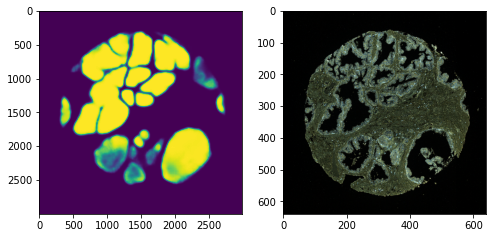

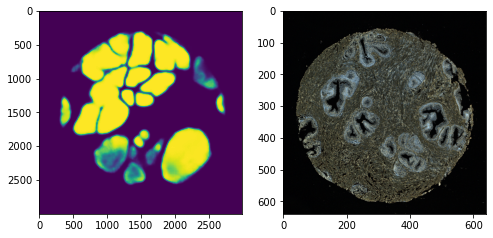

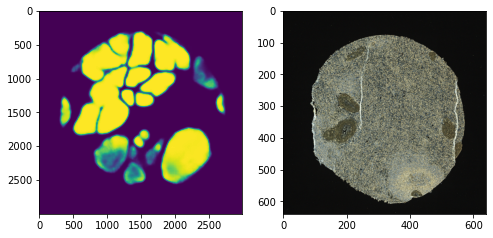

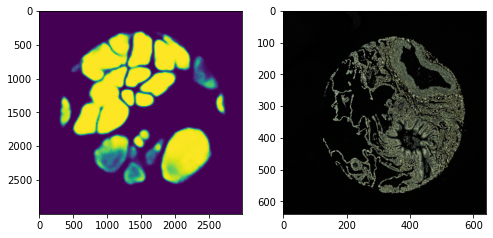

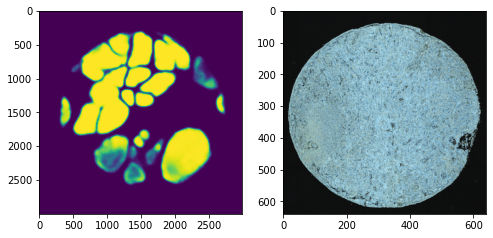

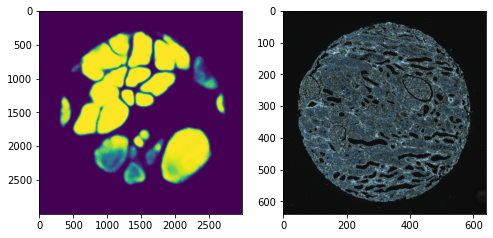

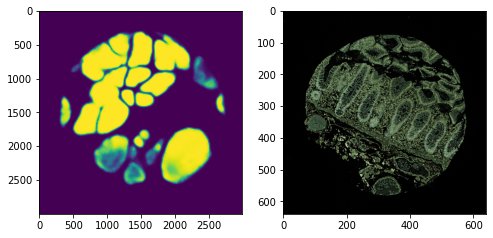

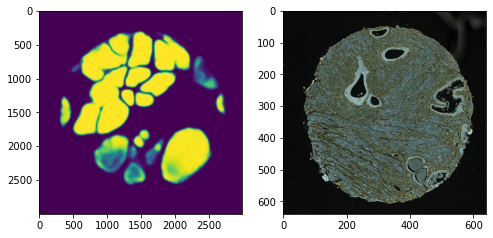

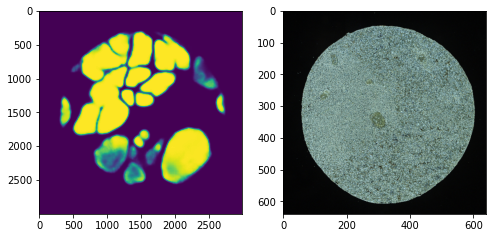

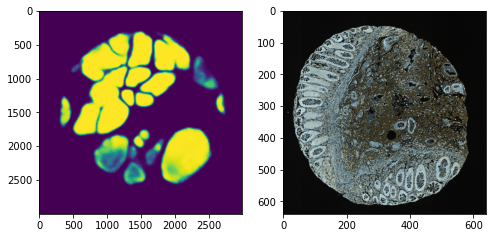

In [111]:
# Plot 10 predictions to verify the trained weights are correctly loaded
test_rows = []
N = 10

for row_idx, row in tqdm(train[:N].iterrows(), total=N):
    # Preprocess Image
    image, image_size = get_image(row['id'], 'train')
    #image_patches = extract_patches(image)
    
    # Make Prediction
    #mask_patches_pred = model.predict(image_patches)
    mask_pred = merge_patches(VAL_Y_PREDS)
    mask_pred_resized = resize_tensor(mask_pred, size=image_size, dtype=np.float32)
    
    fig, axes = plt.subplots(1,2, figsize=(8,4))
    axes[0].imshow(mask_pred_resized)
    axes[1].imshow(image)
    plt.show()
        
    # Resize and Binarize Mask
    mask_binary = (mask_pred_resized > 0.682).astype(np.uint8)
    # Append to Result
    test_rows.append({
        'id': row['id'],
        'rle': rle_encode_less_memory(mask_binary)
    })

# Make Submission CSV

In [112]:
# Make submission DataFrame
test_df = pd.DataFrame(test_rows)

In [113]:
# Write Submission CSV
test_df.to_csv('submission.csv', index=False)

In [114]:
def dice_coef2(y_true, y_pred, smooth=5):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f) + smooth
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / union

#print(mean_dice_coef(mask_pred_resized, mask_binary))
print(dice_coef2(mask_pred_resized,mask_binary))

0.9138037197563583
